# Machine Learning models for fraud detection on vehicle insurance

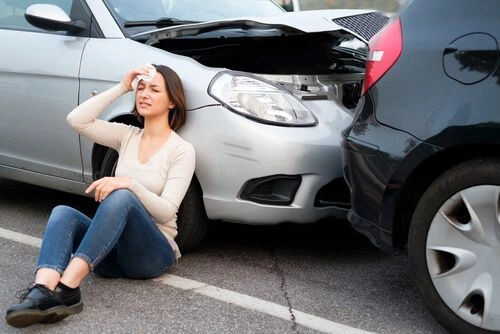

Insurance fraud, as defined by the California Department of Insurance, occurs when someone knowingly lies to obtain a benefit or advantage to which they are not otherwise entitled or someone knowingly denies a benefit that is due and to which someone is entitled. According to the Coalition Against Insurance Fraud, insurance fraud, as a whole, occurs in about 10% of property-casualty insurance losses and steals at least \\$308.6 billion every year from consumers in the United States. Medical care fraud alone accounts for an estimated cost of \\$60 billion every year.

Vehicles are also an essential source of insurance fraud, which consists of false or exaggerated claims related to property damage or personal injuries. Some common fraud practices are staged accidents, phantom passengers or exaggerated injuries. With that said, this project focuses on vehicle fraud claims.

### 1. Pre project
#### 1.1 Loading the packages 

In [1]:
# Loading the packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.metrics import recall_score, classification_report, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, silhouette_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from imblearn.under_sampling import ClusterCentroids 
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN 
from imblearn.under_sampling import EditedNearestNeighbours

import pickle

pd.set_option('display.max_rows', None)
%matplotlib inline

### 1.2 Creating some functions

__error_tab()__ creates a dataframe that will store the values of squared root mean, squared error, accuracy and F1 obtained by the given model.

In [2]:
def error_tab(model_name, y, pred):
    rec = recall_score(y, pred)
    f1 = f1_score(y, pred)

    return pd.DataFrame({'Model Name' : model_name,
                        'Recall Score' : rec,
                        'F1 Score': f1
                        }, index = [0])

### 2. Data Loading

In [3]:
# Importing the dataset

df = pd.read_csv("fraud_oracle.csv")
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


### 3. Data Analysis

After loading the required packages and the dataset, we begin our analysis by using _.shape_ to check how many observations and columns it contains:

In [4]:
# Checking the shape of the dataset

df.shape

(15420, 33)

As we can see, the dataset has a total of 15,420 observations and 33 variables, which are:

    - Month
    - WeekOfMonth
    - DayOfWeek
    - Make
    - AccidentArea
    - DayOfWeekClaimed
    - MonthClaimed
    - WeekOfMonthClaimed
    - Sex
    - MaritalStatus
    - Age
    - Fault
    - PolicyType
    - VehicleCategory
    - VehiclePrice
    - FraudFound_P
    - PolicyNumber
    - RepNumber
    - Deductible
    - DriverRating
    - Days_Policy_Accident
    - Days_Policy_Claim
    - PastNumberOfClaims
    - AgeOfVehicle
    - AgeOfPolicyHolder
    - PoliceReportFile
    - WitnessPresent
    - AgentType
    - NumberOfSuppliments
    - AddressChange_Claim
    - NumberOfCars
    - Year
    - BasePolicy    

Then we proceed to check the data types and if there are null values on each column.

In [5]:
# Checking the info of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

As seen above, the dataset contains mainly object and integer data types, with no null values. Just to check, we can use "df.isnull().sum().sum()", which will return the total number of null values in the dataframe.

In [6]:
print(f'The overall amount of null values is: {df.isnull().sum().sum()}.')

The overall amount of null values is: 0.


Now, we would like to see which are the values in each column, since there are no description about its means. Then, we can classify in categorical or numerical.

In [7]:
for column in df.columns:
    print(column)
    print(df[column].sort_values().unique())

Month
['Apr' 'Aug' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Mar' 'May' 'Nov' 'Oct' 'Sep']
WeekOfMonth
[1 2 3 4 5]
DayOfWeek
['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
Make
['Accura' 'BMW' 'Chevrolet' 'Dodge' 'Ferrari' 'Ford' 'Honda' 'Jaguar'
 'Lexus' 'Mazda' 'Mecedes' 'Mercury' 'Nisson' 'Pontiac' 'Porche' 'Saab'
 'Saturn' 'Toyota' 'VW']
AccidentArea
['Rural' 'Urban']
DayOfWeekClaimed
['0' 'Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday'
 'Wednesday']
MonthClaimed
['0' 'Apr' 'Aug' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Mar' 'May' 'Nov' 'Oct'
 'Sep']
WeekOfMonthClaimed
[1 2 3 4 5]
Sex
['Female' 'Male']
MaritalStatus
['Divorced' 'Married' 'Single' 'Widow']
Age
[ 0 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
Fault
['Policy Holder' 'Third Party']
PolicyType
['Sedan - All Perils' 'Sedan - Collision' 'Sedan - Liability'

Then classification is:

- Categorical Discrete: WeekOfMonth, WeekOfMonthClaimed, Year, Deductible, FraudFound_P, BasePolicy, Make, PoliceReportFiled, PoliceReportFiled, VehicleCategory, MaritalStatus , AccidentArea, Fault, PolicyType;
- Categorical Ordinal: DriverRating, NumberOfSuppliments, AddressChange_Claim, NumberOfCars, PastNumberOfClaims,Days_Policy_Claim, VehiclePrice, Month, MonthClaimed, DayOfWeekClaimed, AgeOfPolicyHolder
- Numerical Continuous: Age, PolicyNumber, RepNumber, AgeOfVehicle

Some variables, like 'NumberOfSuppliments', 'AgeOfPolicyHolder' and others, despite referring to quantity they are divided in groups, that is why they become categorical.

Let's also look at the PolicyNumber column:

In [8]:
df['PolicyNumber'].head(15)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
Name: PolicyNumber, dtype: int64

As we can see, it basiclly follows the index with the difference of minus one unit. So, it is possible to drop this column.

In [9]:
df.drop('PolicyNumber', axis = 1, inplace = True)

### 4. Data Visualization

Following with the project, we will continue with the data analysis using visualization tools, so we can detect important patterns and relationships that could be hidden at first glance.
At first, let's analyse the amount of fraud and non-fraud present in our datset, thus, we can see if our data is balanced or not.


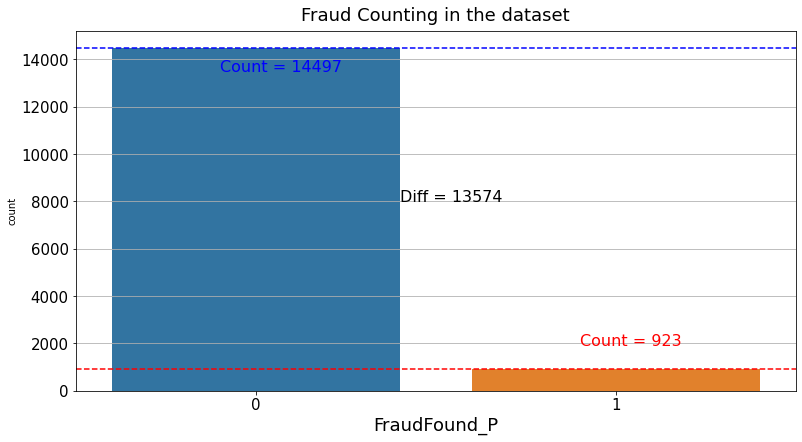

In [10]:
fig = plt.figure(figsize = (10, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.countplot(data = df, x = 'FraudFound_P')
axis.set_title('Fraud Counting in the dataset', fontsize = 18, pad = 10)
axis.set_xlabel('FraudFound_P', fontsize = 18)

axis.tick_params(labelsize=15)
axis.grid(True, axis = 'y');

axis.axhline(y = df[df['FraudFound_P'] == 0].count()[0], color = 'blue', linestyle = '--');
axis.annotate('Count = {}'.format(df[df['FraudFound_P'] == 0].count()[0]), xy = (-0.10, df[df['FraudFound_P'] == 0].count()[0] - 1000), fontsize = 16, color = 'blue')
axis.axhline(y = df[df['FraudFound_P'] == 1].count()[0], color = 'red', linestyle = '--');
axis.annotate('Count = {}'.format(df[df['FraudFound_P'] == 1].count()[0]), xy = (0.9, df[df['FraudFound_P'] == 1].count()[0] + 1000), fontsize = 16, color = 'red')
axis.annotate('Diff = {}'.format(df[df['FraudFound_P'] == 0].count()[0] - df[df['FraudFound_P'] == 1].count()[0]), xy = (0.4, 8000), fontsize = 16, color = 'black')
plt.show()

Our data is very unbalanced, the amount of frauds made is about only 6% of the hole data. Forward, we will explain what it is needed to do in these cases.

Now, we will see the accident characteristics:


We now proceed to view some characteristcs of the accidents.

#### 4.1 Associated with time

We will make some comparisons. First, we will create a dataframe only with FraudFound_P = 1.

We will plot a graph showing the distribution of accidents per month and, after, plot the distribution of fraud per month.

In [11]:
sup = df[['Year', 'MonthClaimed', 'Month', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonth', 'WeekOfMonthClaimed', 'FraudFound_P']]
sup = sup[sup['FraudFound_P'] == 1]
sup.head()

,Year,MonthClaimed,Month,DayOfWeek,DayOfWeekClaimed,WeekOfMonth,WeekOfMonthClaimed,FraudFound_P
28,1994,Sep,Jul,Saturday,Tuesday,1,4,1
52,1994,Jan,Jul,Sunday,Wednesday,3,4,1
53,1994,Aug,Jul,Saturday,Wednesday,4,2,1
94,1994,Jan,Nov,Thursday,Friday,2,3,1
96,1994,Jan,Nov,Friday,Tuesday,2,1,1


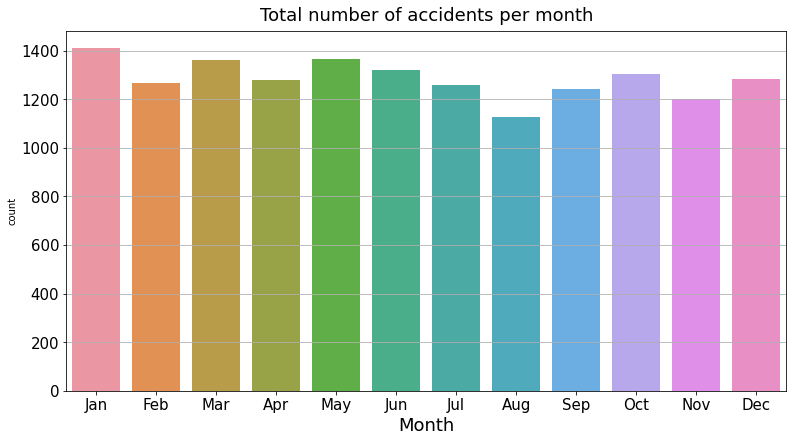

In [12]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='Month', 
                    data=df, 
                    order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.set_title('Total number of accidents per month', fontsize = 18, pad = 10)
ax.set_xlabel('Month', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

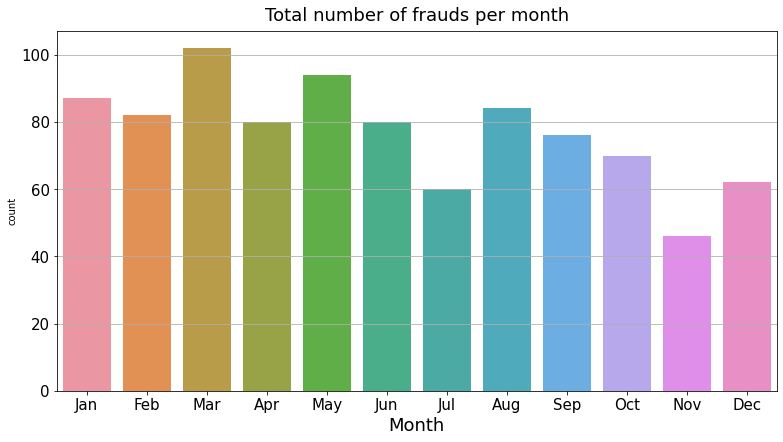

In [13]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='Month', 
                    data=sup, 
                    order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.set_title('Total number of frauds per month', fontsize = 18, pad = 10)
ax.set_xlabel('Month', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

At first, the total number os accidents do not follow a clear pattern throughout the months and the amount of accidents are similar. For the frauds, it also doesn't follow a parttern, just july and october have less fraud, but doesn't seem to have a reason.

Let's analyse the accidents distribution over the years and the amount of frauds per year.

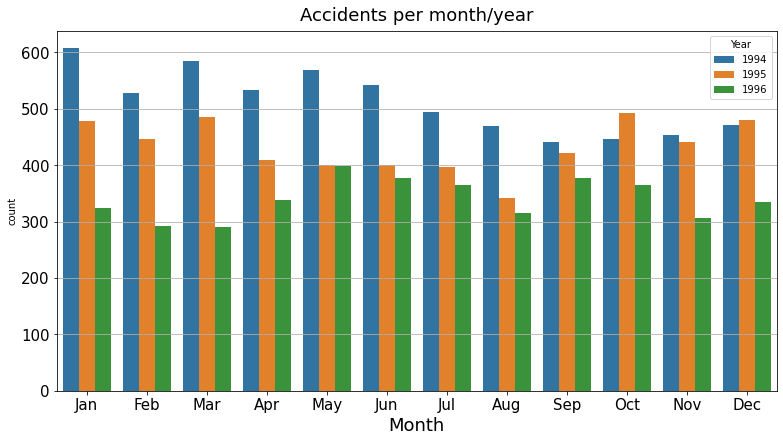

In [14]:
# Number of accidents by year/month

fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
df1 = df[['Month', 'Year']]
ax = sns.countplot(data = df1, x = 'Month', order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],  hue = 'Year');

ax.set_title('Accidents per month/year', fontsize = 18, pad = 10)
ax.set_xlabel('Month', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

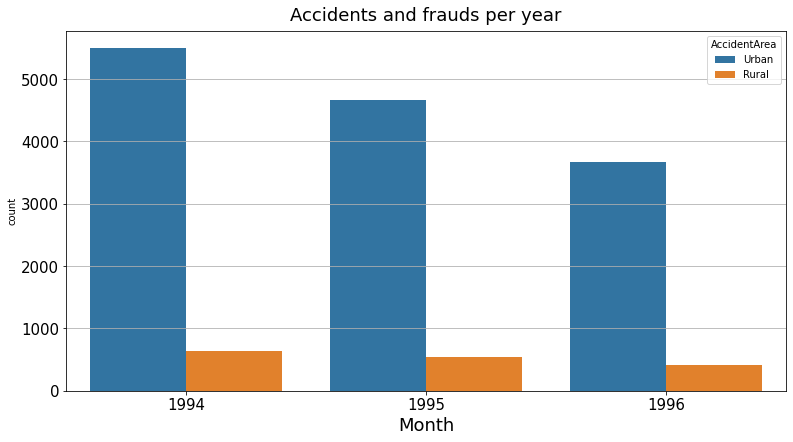

In [15]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
df2 = df[['Year', 'AccidentArea']]
ax = sns.countplot(data = df2, x = 'Year', hue = 'AccidentArea')

ax.set_title('Accidents and frauds per year', fontsize = 18, pad = 10)
ax.set_xlabel('Month', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

In [16]:
frauds_1994 = (sup['Year'] == 1994).sum()
frauds_1995 = (sup['Year'] == 1995).sum()
frauds_1996 = (sup['Year'] == 1996).sum()
acc_1994 = (df['Year'] == 1994).sum()
acc_1995 = (df['Year'] == 1995).sum()
acc_1996 = (df['Year'] == 1996).sum()

print(f'Percentage of frauds in 1994: {frauds_1994/acc_1994*100:.2f}%.')
print(f'Percentage of frauds in 1995: {frauds_1995/acc_1995*100:.2f}%.')
print(f'Percentage of frauds in 1996: {frauds_1996/acc_1996*100:.2f}%.')

Percentage of frauds in 1994: 6.66%.
Percentage of frauds in 1995: 5.79%.
Percentage of frauds in 1996: 5.22%.


Althought the accident pattern remains mostly similar, it can be perceived that it decreased throughout the years. 1994 has the highest number of accidents, while 1996 has the lowest. By making some researchers, apparently there was a change in the drive rules, making the punishments more severe.

The number of frauds also decrease, but the percentage remains almost the same, this means that even the number of accidents decreases, the amount of frauds remains almost the same.

Furthermore, we will display the total accidents for each week day:

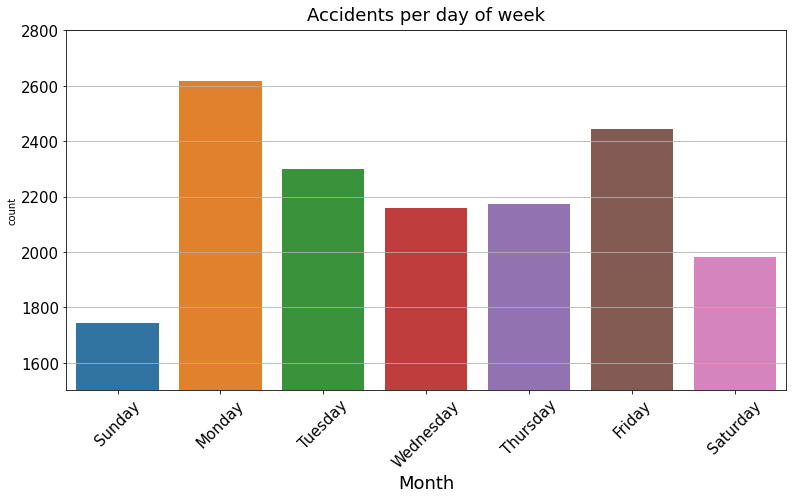

In [17]:
# Number of accidents by weekday
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='DayOfWeek',
                    data=df,
                    order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
ax.set(ylim=(1500,2800))
plt.xticks(rotation=45);

ax.set_title('Accidents per day of week', fontsize = 18, pad = 10)
ax.set_xlabel('Month', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

As presented above, the accidents are mainly concentrated on weekdays, with weekends having the lowest cases.
Now that we saw when the accidents occur, we proceed to understand the vehicle characteristics and the profile of the ones involved on it.

#### 4.2 Associated to people

Let's analyse the accidents by social status.

In [18]:
df['MaritalStatus'].value_counts()

Married     10625
Single       4684
Divorced       76
Widow          35
Name: MaritalStatus, dtype: int64

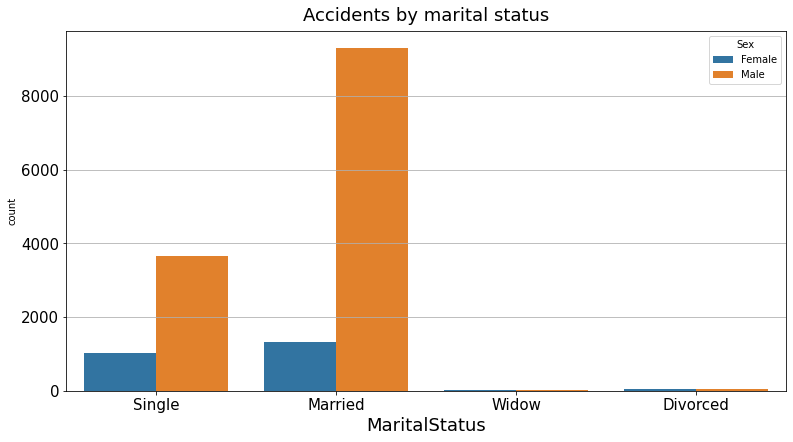

In [19]:
# Number of accidents by marital status
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='MaritalStatus',
                    hue = 'Sex',
                    data=df)
ax.set_title('Accidents by marital status', fontsize = 18, pad = 10)
ax.set_xlabel('MaritalStatus', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

In our dataset, married represents 70% of total and single population represents 30% of it. So, it was expected that the amount of married people envolved in accidents was higher than the others, since most of the population is maried. 

Now, we will analyse the distribution of age and sex of our dataset.

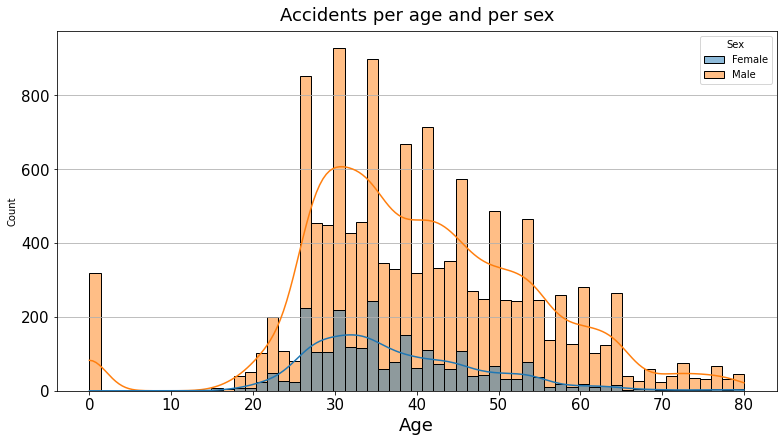

In [20]:
fig = plt.figure(figsize = (10, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.histplot(data = df, x = 'Age', hue = 'Sex', kde = True)
axis.set_title('Accidents per age and per sex', fontsize = 18, pad = 10)
axis.set_xlabel('Age', fontsize = 18)

axis.tick_params(labelsize=15)
axis.grid(True, axis = 'y');

As we can see, drivers around 30 years old present the highest number of accidents, for both male and female drivers. Although most of the data are between 16 and 80 years old, some of it displays an 0 value for 'Age', possibly pointing to an error on the data that must be cleaned afterwards.

#### 4.3 Car characteristics

From now on, we will visualize the car characteristics. The 'make' dict was created to order the plot from the higher to the lowest value.

In [21]:
make = df['Make'].value_counts().to_dict()
make.keys()

dict_keys(['Pontiac', 'Toyota', 'Honda', 'Mazda', 'Chevrolet', 'Accura', 'Ford', 'VW', 'Dodge', 'Saab', 'Mercury', 'Saturn', 'Nisson', 'BMW', 'Jaguar', 'Porche', 'Mecedes', 'Ferrari', 'Lexus'])

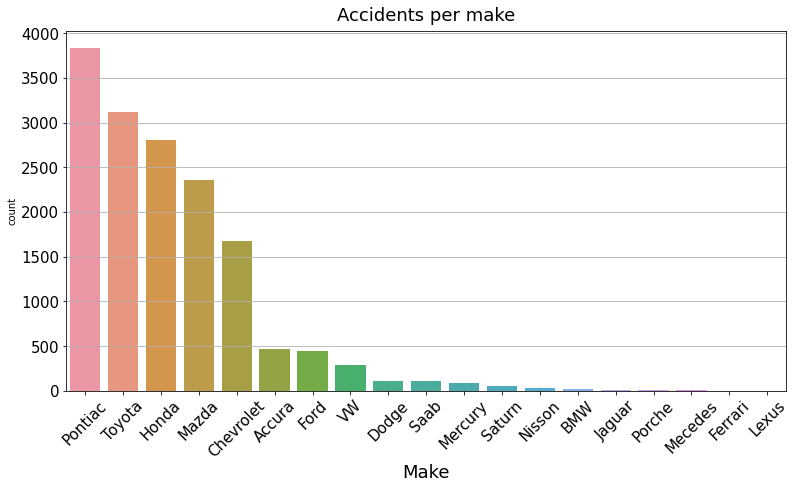

In [22]:
# Number of accidents by car manufacturer
fig = plt.figure(figsize = (10, 5))
axis = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='Make',
                    data=df, order = make.keys())
axis.set_title('Accidents per make', fontsize = 18, pad = 10)
axis.set_xlabel('Make', fontsize = 18)

axis.tick_params(labelsize=15)
axis.grid(True, axis = 'y');
plt.xticks(rotation=45);

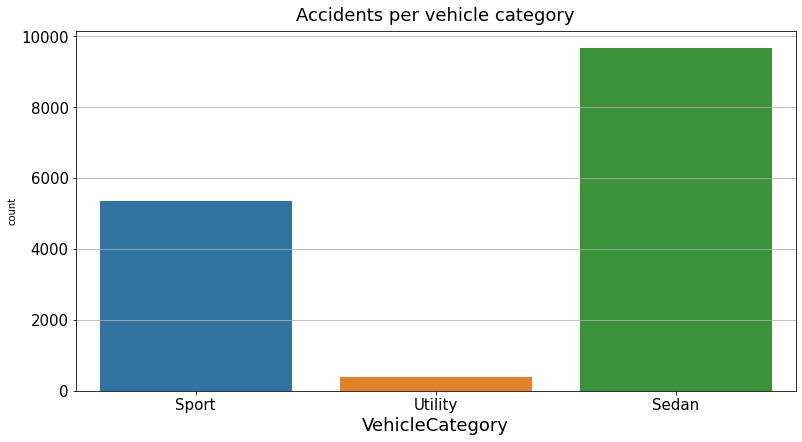

In [23]:
# Number of accidents by category
fig = plt.figure(figsize = (10, 5))
axis = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='VehicleCategory',
                    data=df)
axis.set_title('Accidents per vehicle category', fontsize = 18, pad = 10)
axis.set_xlabel('VehicleCategory', fontsize = 18)

axis.tick_params(labelsize=15)
axis.grid(True, axis = 'y');

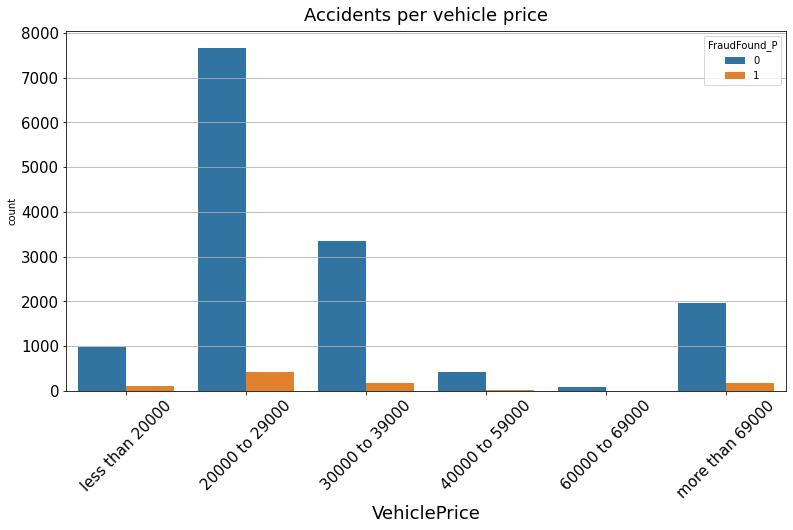

In [24]:
# Number of accidents by car value

fig = plt.figure(figsize = (10, 5))
axis = fig.add_axes([0, 0, 1, 1])
price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']
ax = sns.countplot(x='VehiclePrice',
                    data=df,
                    order=price_order, hue = 'FraudFound_P')
axis.set_title('Accidents per vehicle price', fontsize = 18, pad = 10)
axis.set_xlabel('VehiclePrice', fontsize = 18)

axis.tick_params(labelsize=15)
axis.grid(True, axis = 'y');
plt.xticks(rotation=45);

We can see that, most accidents that occur involves sedan cars, with 6 years or more, that costs between US\\$ 20,000.00 and US\\$ 29,000.00.


#### 4.3 Hypothesis

Based on the graphs we alredy saw, we can make some hypotesis and test them:

1 - The time distance between the accident and the claim has influence in fraud presence;

2 - Men fraud more than women;

3 - Accidents with no witness are more likely to be defrauded;

4 - The drive rating influences in the number of accident;

5 - Third parties frauds more than policy holders;

6 - Older cars are envolved in more accidents and, then, fraud more;

7 - There are more accidents in urban area, but this doesn't affect the amount of fraud;

8 - Accidents with no police report filled are more likely to be defrauded.

#### 4.3.1 Testing the hypotesis

#### 1- The time distance between the accident and the claim has influence in fraud presence

By time distance, we refer to the amount of time spent between the accident and the claim.

First, we will create a dataframe with only time attributes, as follows:

In [25]:
time = df[['MonthClaimed', 'Month', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonth', 'WeekOfMonthClaimed', 'FraudFound_P']]
time.head()

,MonthClaimed,Month,DayOfWeek,DayOfWeekClaimed,WeekOfMonth,WeekOfMonthClaimed,FraudFound_P
0,Jan,Dec,Wednesday,Tuesday,5,1,0
1,Jan,Jan,Wednesday,Monday,3,4,0
2,Nov,Oct,Friday,Thursday,5,2,0
3,Jul,Jun,Saturday,Friday,2,1,0
4,Feb,Jan,Monday,Tuesday,5,2,0


Let's create some extra columns called:
* samemonth: refers to the accident and claim that occurred at the same month;
* sameweek: refers to the accident and claim that occurred at the same week;
* sameday: refers to the accident and claim that occurred at the same day.

Then, we will create some graphs to compare our results.

In [26]:
time2 = time.copy()
time2['samemonth'] = 'na'
time2['sameday'] = 'na'
time2['sameweek'] = 'na'
time2['samemonth'] = time2[['Month', 'MonthClaimed']].apply(lambda x: 1 if x['Month'] == x['MonthClaimed']
                                                         else 0, axis = 1)
time2['sameweek'] = time2[['WeekOfMonth', 'WeekOfMonthClaimed', 'samemonth']].apply(lambda x: 1 if (x['WeekOfMonth'] == x['WeekOfMonthClaimed']) & (x['samemonth'] == 1)
                                                         else 0, axis = 1)
time2['sameday'] = time2[['DayOfWeek', 'DayOfWeekClaimed', 'sameweek']].apply(lambda x: 1 if (x['DayOfWeek'] == x['DayOfWeekClaimed']) & (x['sameweek'] == 1)
                                                         else 0, axis = 1)
time2.head()                                            

,MonthClaimed,Month,DayOfWeek,DayOfWeekClaimed,WeekOfMonth,WeekOfMonthClaimed,FraudFound_P,samemonth,sameday,sameweek
0,Jan,Dec,Wednesday,Tuesday,5,1,0,0,0,0
1,Jan,Jan,Wednesday,Monday,3,4,0,1,0,0
2,Nov,Oct,Friday,Thursday,5,2,0,0,0,0
3,Jul,Jun,Saturday,Friday,2,1,0,0,0,0
4,Feb,Jan,Monday,Tuesday,5,2,0,0,0,0


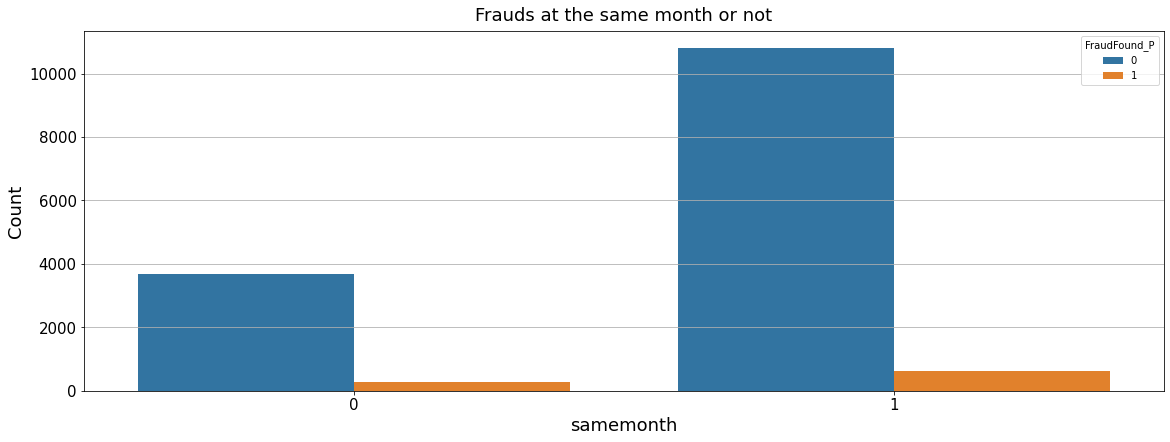

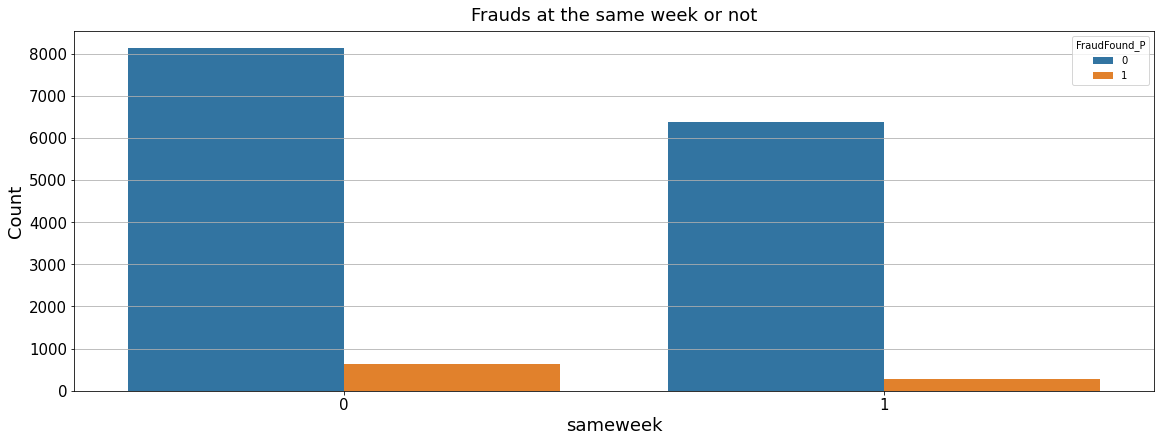

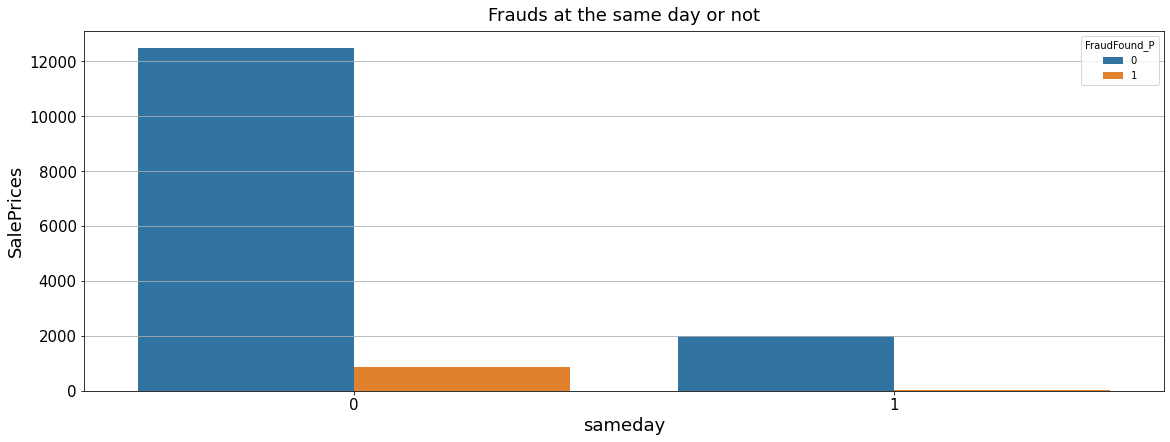

In [27]:
fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.countplot(data = time2, x = 'samemonth', hue = 'FraudFound_P')
axis.set_title('Frauds at the same month or not', fontsize = 18, pad = 10)
axis.set_xlabel('samemonth', fontsize = 18)
axis.set_ylabel('Count', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.countplot(data = time2, x = 'sameweek', hue = 'FraudFound_P')
axis.set_title('Frauds at the same week or not', fontsize = 18, pad = 10)
axis.set_xlabel('sameweek', fontsize = 18)
axis.set_ylabel('Count', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

fig = plt.figure(figsize = (15, 5))
axis = fig.add_axes([0, 0, 1, 1])
sns.countplot(data = time2, x = 'sameday', hue = 'FraudFound_P')
axis.set_title('Frauds at the same day or not', fontsize = 18, pad = 10)
axis.set_xlabel('sameday', fontsize = 18)
axis.set_ylabel('SalePrices', fontsize = 18)
axis.tick_params(labelsize=15);
axis.grid(True, axis = 'y')

By the graphs, we can see that most of the frauds are claimed in the same month, but not at the same week or day. I think it is better if we work with some percentages.

Let's create some variables:
* total_fraud is the total amount of frauds registered;
* same_month is the total amount of frauds registered for the accidents and claims that happened at the same month;
* diff_mont is the total amount of frauds registered for the accidents and claims that happened in differents months;
* same_week is the total amount of frauds registered for the accidents and claims that happened at the same week;
* diff_week is the total amount of frauds registered for the accidents and claims that happened in differents weeks;
* same_day is the total amount of frauds registered for the accidents and claims that happened at the same day;
* diff_day is the total amount of frauds registered for the accidents and claims that happened in differents days.

In [28]:
total_fraud = ((time2['samemonth'] == 0) & (time2['FraudFound_P'] == 1)).sum() + ((time2['samemonth'] == 1) & (time2['FraudFound_P'] == 1)).sum()
same_month = ((time2['samemonth'] == 1) & (time2['FraudFound_P'] == 1)).sum()
diff_mont = ((time2['samemonth'] == 0) & (time2['FraudFound_P'] == 1)).sum()
same_week = ((time2['sameweek'] == 1) & (time2['FraudFound_P'] == 1)).sum()
diff_week = ((time2['sameweek'] == 0) & (time2['FraudFound_P'] == 1)).sum()
same_day = ((time2['sameday'] == 1) & (time2['FraudFound_P'] == 1)).sum()
diff_day = ((time2['sameday'] == 0) & (time2['FraudFound_P'] == 1)).sum()

print(f'Percentage of frauds that the accident and claim happened at the same month: {same_month / total_fraud * 100:.2f}%.')
print(f'Percentage of frauds that the accident and claim happened at the same week: {same_week / total_fraud * 100:.2f}%.')
print(f'Percentage of frauds that the accident and claim happened at the same day: {same_day / total_fraud * 100:.2f}%.')

Percentage of frauds that the accident and claim happened at the same month: 68.58%.
Percentage of frauds that the accident and claim happened at the same week: 30.88%.
Percentage of frauds that the accident and claim happened at the same day: 4.55%.


So, the time that the person takes to claim seems to have some influence in fraud, since almost 70% of the frauds takes 1 month to be claimed.

#### 2 - Men fraud more than women



In [29]:
total_frauds = (df['FraudFound_P']==1).sum()
total_frauds_women = ((df['FraudFound_P']==1) & (df['Sex'] == 'Female')).sum()
tot_acc_women = (df['Sex'] == 'Female').sum()
total_frauds_men = ((df['FraudFound_P']==1) & (df['Sex'] == 'Male')).sum()
tot_acc_men= (df['Sex'] == 'Male').sum()
print(f'Frauds done by men related to total fraud: {total_frauds_men/total_frauds*100:.2f}%.')
print(f'Frauds done by men: {total_frauds_men/tot_acc_men*100:.2f}%.')
print(f'Frauds done by women: {total_frauds_women/tot_acc_women*100:.2f}%.')
print(f'Relation between frauds done by men and women: {total_frauds_men/total_frauds_women:.2f}')
print(f'Relation between number of accidents done by men and women: {tot_acc_men/tot_acc_women:.2f}')

Frauds done by men related to total fraud: 88.62%.
Frauds done by men: 6.29%.
Frauds done by women: 4.34%.
Relation between frauds done by men and women: 7.79
Relation between number of accidents done by men and women: 5.37


As we can see, men are responsable for almost 89% of the frauds, it is almost 8 times greater! But, they are also involved in 5 times more accidents. To make a fair comparison we need to evaluate the total number of accidents caused by each gender.

That said, for the accidents caused by men, 6% of them frauds the insurance, while for accidents caused by women, 4% of them are detected as fraudulent. The difference has decreased significantly, but men still are responsible for the major share of fraudulent claims.

#### 3 - Accidents with no witness are more likely to be fraudulent

We start by creating a graph with the amount of accidents with witness presence.

In [30]:
num = ((df['FraudFound_P']==1) & (df['WitnessPresent'] == 'No')).sum()
num

920

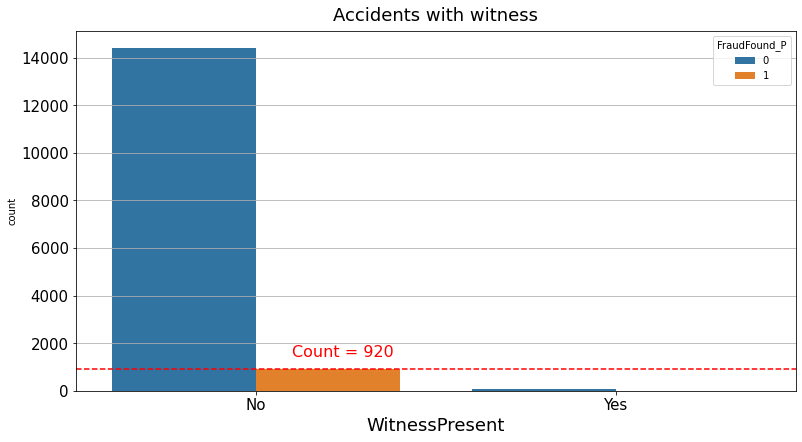

In [31]:
# Number of accidents by witness presence
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='WitnessPresent',
                    data=df, hue = 'FraudFound_P')

ax.set_title('Accidents with witness', fontsize = 18, pad = 10)
ax.set_xlabel('WitnessPresent', fontsize = 18)
ax.axhline(y = num, color = 'red', linestyle = '--');
ax.annotate('Count = {}'.format(num), xy = (0.1, num+500), fontsize = 16, color = 'red')
ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

That is an interesting result since only 3 fraudulent claims had a witness on the accident. It means that in 99.67% of the frauds, there was no witness.

#### 4 - The drive rating influences in the number of accident

Now, we will create a graph showing the amount of accidents by the driving rating.



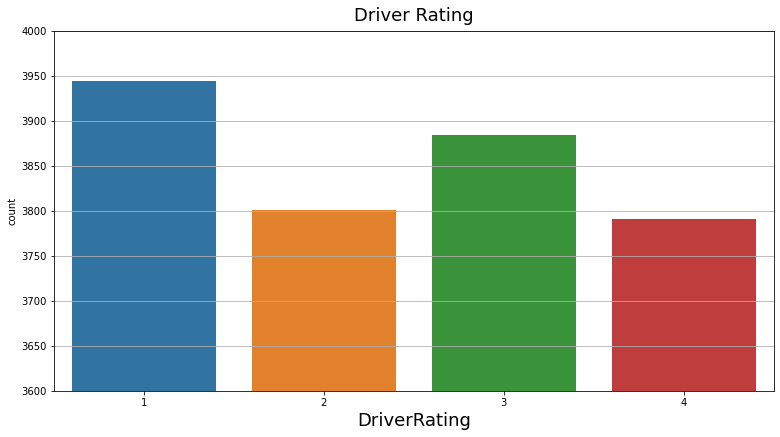

In [32]:
# Number of accidents by driver rating
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='DriverRating',
                    data=df)
ax.set(ylim=(3600,4000))
ax.set_title('Driver Rating', fontsize = 18, pad = 10)
ax.set_xlabel('DriverRating', fontsize = 18)
ax.grid(True, axis = 'y');

The maximum rating is 4, but we can't see any pattern in the number of accidents by the driver rating. Drivers with rate 1 have the higher amount of accident, but, drivers with rating 3 have the second higher. So, we believe that this is not an important attribute.

#### 5 - Third parties frauds more than policy holders;

We will see if the policy holders are the main fraudsters.

In [33]:
num = ((df['FraudFound_P']==1) & (df['Fault'] == 'Policy Holder')).sum()
num

886

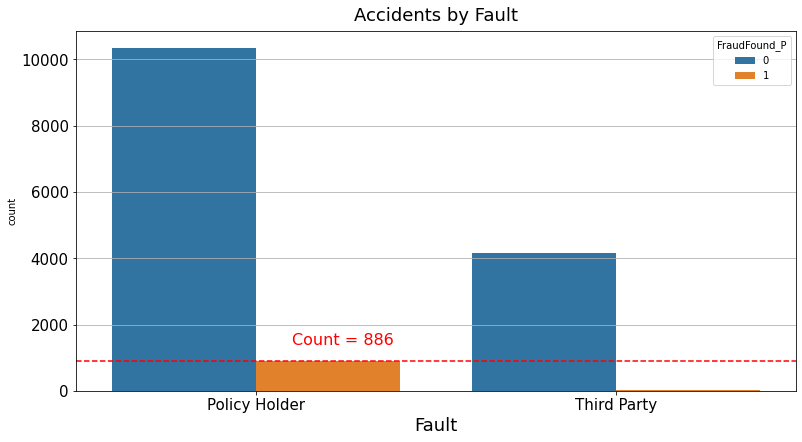

In [34]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='Fault',
                    data=df, hue = 'FraudFound_P')

ax.set_title('Accidents by Fault', fontsize = 18, pad = 10)
ax.set_xlabel('Fault', fontsize = 18)
ax.axhline(y = num, color = 'red', linestyle = '--');
ax.annotate('Count = {}'.format(num), xy = (0.1, num+500), fontsize = 16, color = 'red')
ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

As seen above, most of the accidents are reported by the policy holder while less than half are reported by a third party. 95.99% of the frauds are done by the policy holder, so, this is an important attribute.

#### 6 - Older cars are envolved in more accidents and, then, fraud more



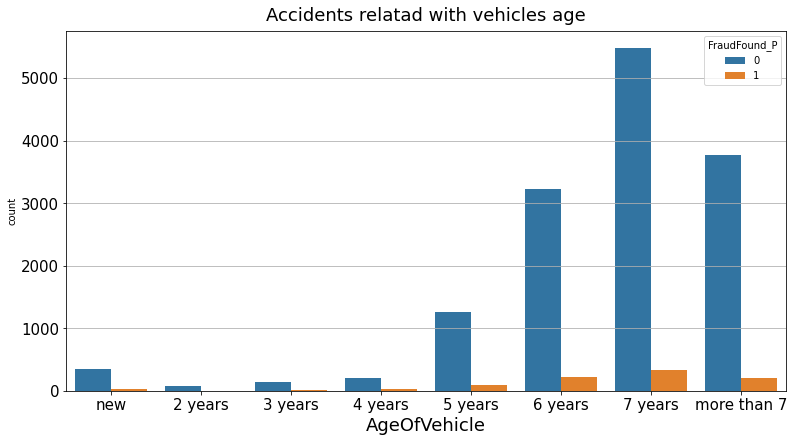

In [35]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='AgeOfVehicle',
                    data=df, hue = 'FraudFound_P', order = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'])

ax.set_title('Accidents relatad with vehicles age', fontsize = 18, pad = 10)
ax.set_xlabel('AgeOfVehicle', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

There is an increase in the number of accidents as the car age increases up to 7 years, but, it decreases for cars older than 7 years and, also for new cars to 2 years old cars. The amount of frauds follows the same behavior. As there seems to exist a pattern, we believe that this is an important variable.

#### 7 - There are more accidents in urban area, but this doesn't affect the amount of fraud

Now, let's plot a graph showing the distribution of accidents in each area.

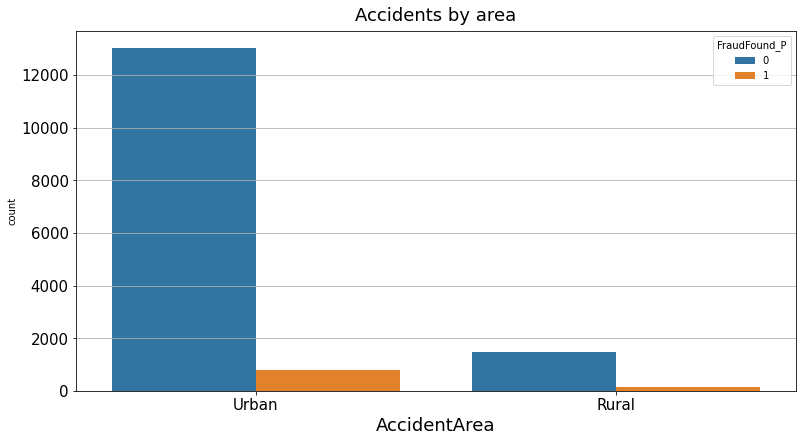

In [36]:
# Number of accidents by area

fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='AccidentArea',
                    data=df, hue = 'FraudFound_P')

ax.set_title('Accidents by area', fontsize = 18, pad = 10)
ax.set_xlabel('AccidentArea', fontsize = 18)

ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

As expected, due to population density, there are more car accidents that occur within urban perimeter. But, let's see if the amout of fraud is different. We will work again with percentage.

In [37]:
total_frauds_urban = ((df['FraudFound_P']==1) & (df['AccidentArea'] == 'Urban')).sum()
tot_acc_urban = (df['AccidentArea'] == 'Urban').sum()
total_frauds_rural = ((df['FraudFound_P']==1) & (df['AccidentArea'] == 'Rural')).sum()
tot_acc_rural= (df['AccidentArea'] == 'Rural').sum()
print(f'Frauds done in urban area related to total fraud: {total_frauds_urban/total_fraud*100:.2f}%.')
print(f'Frauds done in urban area related to total accidents in urban area: {total_frauds_urban/tot_acc_urban*100:.2f}%.')
print(f'Frauds done in rural area related to total accidents in rural area: {total_frauds_rural/tot_acc_rural*100:.2f}%.')
print(f'Relation between frauds done in urban and rural areas: {total_frauds_urban/total_frauds_rural:.2f}.')
print(f'Relation between number of accidents done in urban and rural areas: {tot_acc_urban/tot_acc_rural:.2f}.')

Frauds done in urban area related to total fraud: 85.59%.
Frauds done in urban area related to total accidents in urban area: 5.72%.
Frauds done in rural area related to total accidents in rural area: 8.32%.
Relation between frauds done in urban and rural areas: 5.94.
Relation between number of accidents done in urban and rural areas: 8.65.


Frauds in urban area represents 82% of the total number of frauds found. But the number of accidents in urban area is 8 times higher than in rural area, that is why this amount is larger. On the other hand, if we analyse by the total number of accidents in each area, it is possible to see that there are more frauds in accidents in rural area than in urban area! Which means that accidents that happens in rural area tend to be more defrauded.

#### 8 - Accidents with no police report filled are more likely to be defrauded.

Let's create a graph counting the number of accidents separated by police report.

In [38]:
num = ((df['FraudFound_P']==1) & (df['PoliceReportFiled'] == 'No')).sum()
num

907

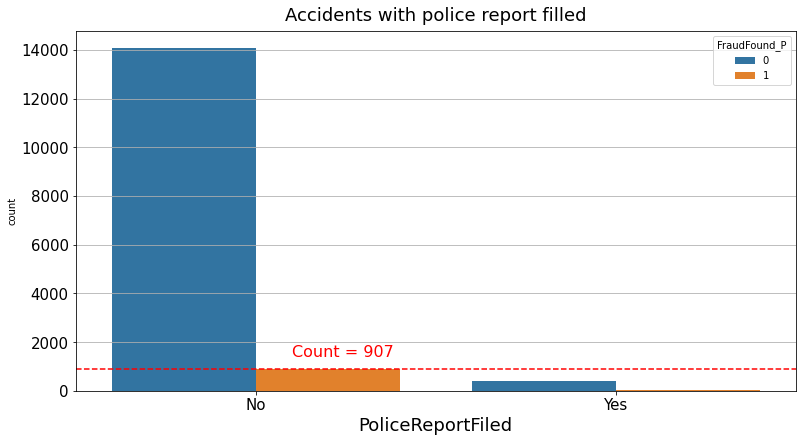

In [39]:
# Number of accidents by area

fig = plt.figure(figsize = (10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax = sns.countplot(x='PoliceReportFiled',
                    data=df, hue = 'FraudFound_P')

ax.set_title('Accidents with police report filled', fontsize = 18, pad = 10)
ax.set_xlabel('PoliceReportFiled', fontsize = 18)
ax.axhline(y = num, color = 'red', linestyle = '--');
ax.annotate('Count = {}'.format(num), xy = (0.1, num+500), fontsize = 16, color = 'red')
ax.tick_params(labelsize=15)
ax.grid(True, axis = 'y');

Despite the number of frauds with no police report filled represents 95% of the total number of frauds, in 97% of the accidents that werent defrauded the police report wasn't done. So, there is no correlation between these variables.

### 5. Data Preparation

Now that the visualization step is done, we proceed to prepare the data to the models. We take measures such as data cleaning, feature selection, feature engineering and so on, to make sure that it is properly prepared so we avoid the "Garbage In - Garbage Out" scenario on the modelling phase.

First, we will remove the observations were ages = 0 from the data set. An __important__ thing to check is the index, since we dropped some rows, there will be missing index. This can lead to NaN values when executing the ML model.

In [40]:
# Cleaning the "0" values on the "Age" feature

i = df[df['Age'] == 0].index
df = df.drop(i)
df['Age'].unique()

array([21, 34, 47, 65, 27, 20, 36, 30, 42, 71, 52, 28, 61, 38, 41, 32, 40,
       63, 31, 45, 60, 39, 55, 35, 44, 72, 29, 37, 59, 49, 50, 26, 48, 64,
       33, 74, 23, 25, 56, 16, 68, 18, 51, 22, 53, 46, 43, 57, 54, 69, 67,
       19, 78, 77, 75, 80, 58, 73, 24, 76, 62, 79, 70, 17, 66],
      dtype=int64)

In [41]:
df.tail(10)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
15410,Nov,3,Sunday,Dodge,Urban,Tuesday,Nov,4,Female,Single,...,7 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,Collision
15411,Nov,4,Tuesday,Honda,Rural,Wednesday,Nov,5,Male,Married,...,7 years,36 to 40,No,No,External,none,no change,1 vehicle,1996,All Perils
15412,Nov,4,Tuesday,Pontiac,Urban,Wednesday,Nov,4,Female,Single,...,5 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,Liability
15413,Nov,4,Thursday,Mazda,Urban,Monday,Nov,4,Male,Married,...,7 years,36 to 40,Yes,No,External,1 to 2,no change,1 vehicle,1996,Liability
15414,Nov,4,Friday,Chevrolet,Urban,Monday,Nov,4,Male,Single,...,7 years,51 to 65,No,No,External,1 to 2,4 to 8 years,2 vehicles,1996,Collision
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils
15419,Dec,2,Wednesday,Toyota,Urban,Thursday,Dec,3,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision


In [42]:
#reseting the index

df.reset_index(inplace = True)
df.drop('index', axis = 1, inplace = True)
df.tail()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
15095,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15096,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15097,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15098,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils
15099,Dec,2,Wednesday,Toyota,Urban,Thursday,Dec,3,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision


In [43]:
df.shape

(15100, 32)

At fist, we remove the rows with 0 values on the "Age" column and we can see that there was 320 entries with 0 values.
After cleaning the dataset, we proceed to format it, transforming certain "object" features to a proper data type and values.
We begin by creating a new column with "datetime" data type:

In [44]:
df['Month_Year'] = df['Month']+ '/' + df['Year'].astype(str)
df['Month_Year'] = pd.to_datetime(df['Month_Year'], format='%b/%Y')
print(df['Month_Year'].head())
df['Month_Year'] = df['Month_Year'].astype('str')
print(df['Month_Year'].head())

0   1994-12-01
1   1994-01-01
2   1994-10-01
3   1994-06-01
4   1994-01-01
Name: Month_Year, dtype: datetime64[ns]
0    1994-12-01
1    1994-01-01
2    1994-10-01
3    1994-06-01
4    1994-01-01
Name: Month_Year, dtype: object


With the proper data type for month and year, we proceed to transform all categorical columns, using one-hot encoding for variables with no natural ordering and ordinal encoding otherwise:

In [45]:
ohe = OneHotEncoder()
feat_array = ohe.fit_transform(df[['Make', 'MaritalStatus', 'VehicleCategory', 
                                    'AccidentArea', 'Sex', 'Fault',  'PolicyType', 'WitnessPresent', 'PoliceReportFiled'  
                                    , 'AgentType', 'BasePolicy']]).toarray()

oe = OrdinalEncoder(categories = [['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000'], 
                                  ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'] 
                                  , df['AgeOfPolicyHolder'].sort_values().unique() 
                                  , ['none', '1 to 7','8 to 15', '15 to 30', 'more than 30'] 
                                  , ['8 to 15', '15 to 30', 'more than 30'] 
                                  , df['PastNumberOfClaims'].sort_values().unique() 
                                  , ['none', '1 to 2', '3 to 5', 'more than 5'] 
                                  , ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years'] 
                                  , df['NumberOfCars'].sort_values().unique()])
feat_array_oe = oe.fit_transform(df[['VehiclePrice', 'AgeOfVehicle', 'AgeOfPolicyHolder' 
                                    , 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims' 
                                    , 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']])

In [46]:
ohe.categories_

[array(['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda',
        'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson',
        'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'],
       dtype=object),
 array(['Divorced', 'Married', 'Single', 'Widow'], dtype=object),
 array(['Sedan', 'Sport', 'Utility'], dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Policy Holder', 'Third Party'], dtype=object),
 array(['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability',
        'Sport - All Perils', 'Sport - Collision', 'Sport - Liability',
        'Utility - All Perils', 'Utility - Collision',
        'Utility - Liability'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['External', 'Internal'], dtype=object),
 array(['All Perils', 'Collision', 'Liability'], dtype=object)]

In [47]:
oe.categories_

[array(['less than 20000', '20000 to 29000', '30000 to 39000',
        '40000 to 59000', '60000 to 69000', 'more than 69000'],
       dtype=object),
 array(['new', '2 years', '3 years', '4 years', '5 years', '6 years',
        '7 years', 'more than 7'], dtype=object),
 array(['18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40',
        '41 to 50', '51 to 65', 'over 65'], dtype=object),
 array(['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30'],
       dtype=object),
 array(['8 to 15', '15 to 30', 'more than 30'], dtype=object),
 array(['1', '2 to 4', 'more than 4', 'none'], dtype=object),
 array(['none', '1 to 2', '3 to 5', 'more than 5'], dtype=object),
 array(['no change', 'under 6 months', '1 year', '2 to 3 years',
        '4 to 8 years'], dtype=object),
 array(['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
       dtype=object)]

In [48]:
# Merging all labels on a single array

feat_labels = ohe.categories_

x = feat_labels[0]
for i in range(1, len(feat_labels)):
    x = np.concatenate((x, feat_labels[i]))

feature_labels = x
feature_labels

array(['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda',
       'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson',
       'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW', 'Divorced',
       'Married', 'Single', 'Widow', 'Sedan', 'Sport', 'Utility', 'Rural',
       'Urban', 'Female', 'Male', 'Policy Holder', 'Third Party',
       'Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability',
       'Sport - All Perils', 'Sport - Collision', 'Sport - Liability',
       'Utility - All Perils', 'Utility - Collision',
       'Utility - Liability', 'No', 'Yes', 'No', 'Yes', 'External',
       'Internal', 'All Perils', 'Collision', 'Liability'], dtype=object)

In [49]:
# Renaming selectec feature labels

feature_labels[-9] = 'WitnessPresent_No'
feature_labels[-8] = 'WitnessPresent_Yes'
feature_labels[-7] = 'PoliceReportFiled_No'
feature_labels[-6] = 'PoliceReportFiled_Yes'
feature_labels

array(['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda',
       'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson',
       'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW', 'Divorced',
       'Married', 'Single', 'Widow', 'Sedan', 'Sport', 'Utility', 'Rural',
       'Urban', 'Female', 'Male', 'Policy Holder', 'Third Party',
       'Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability',
       'Sport - All Perils', 'Sport - Collision', 'Sport - Liability',
       'Utility - All Perils', 'Utility - Collision',
       'Utility - Liability', 'WitnessPresent_No', 'WitnessPresent_Yes',
       'PoliceReportFiled_No', 'PoliceReportFiled_Yes', 'External',
       'Internal', 'All Perils', 'Collision', 'Liability'], dtype=object)

In [50]:
feature_labels.shape

(50,)

In [51]:
vars_ohe = pd.DataFrame(feat_array, columns = feature_labels)
vars_ohe.head()

,Accura,BMW,Chevrolet,Dodge,Ferrari,Ford,Honda,Jaguar,Lexus,Mazda,...,Utility - Liability,WitnessPresent_No,WitnessPresent_Yes,PoliceReportFiled_No,PoliceReportFiled_Yes,External,Internal,All Perils,Collision,Liability
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


Since we created the columns _All Perils_, _Collision_ and _Liability_ for policy type, we will drop the old ones:

In [52]:
vars_ohe = vars_ohe.drop(columns=['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability',
       'Sport - All Perils', 'Sport - Collision', 'Sport - Liability',
       'Utility - All Perils', 'Utility - Collision',
       'Utility - Liability'])
vars_ohe.columns

Index(['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda',
       'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac',
       'Porche', 'Saab', 'Saturn', 'Toyota', 'VW', 'Divorced', 'Married',
       'Single', 'Widow', 'Sedan', 'Sport', 'Utility', 'Rural', 'Urban',
       'Female', 'Male', 'Policy Holder', 'Third Party', 'WitnessPresent_No',
       'WitnessPresent_Yes', 'PoliceReportFiled_No', 'PoliceReportFiled_Yes',
       'External', 'Internal', 'All Perils', 'Collision', 'Liability'],
      dtype='object')

In [53]:
vars_oe = pd.DataFrame(feat_array_oe, columns = ['VehiclePrice', 'AgeOfVehicle', 'AgeOfPolicyHolder' 
                                    , 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims' 
                                    , 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars'])
vars_oe.head()

,VehiclePrice,AgeOfVehicle,AgeOfPolicyHolder,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,NumberOfSuppliments,AddressChange_Claim,NumberOfCars
0,5.0,2.0,2.0,4.0,2.0,3.0,0.0,2.0,2.0
1,5.0,5.0,3.0,4.0,2.0,3.0,0.0,0.0,0.0
2,5.0,6.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0
3,1.0,7.0,6.0,4.0,2.0,0.0,3.0,0.0,0.0
4,5.0,4.0,3.0,4.0,2.0,3.0,0.0,0.0,0.0


In [54]:
aux = df.drop(['VehiclePrice', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 
                'Make', 'MaritalStatus', 'VehicleCategory', 'AccidentArea', 'Sex', 'Fault',  'PolicyType', 'WitnessPresent', 'PoliceReportFiled', 'AgentType', 'BasePolicy'], axis = 1)
aux.drop(['Month_Year', 'Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'FraudFound_P', 'Year'], axis = 1, inplace = True)
aux.head()

,Age,RepNumber,Deductible,DriverRating
0,21,12,300,1
1,34,15,400,4
2,47,7,400,3
3,65,4,400,2
4,27,3,400,1


In [55]:
# Merging the dummy variables with the dataset aux and the target variable

df_final = pd.concat([aux, vars_ohe, vars_oe, df['FraudFound_P']], axis=1)
df_final.head()

,Age,RepNumber,Deductible,DriverRating,Accura,BMW,Chevrolet,Dodge,Ferrari,Ford,...,VehiclePrice,AgeOfVehicle,AgeOfPolicyHolder,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,FraudFound_P
0,21,12,300,1,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,2.0,2.0,4.0,2.0,3.0,0.0,2.0,2.0,0
1,34,15,400,4,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,3.0,4.0,2.0,3.0,0.0,0.0,0.0,0
2,47,7,400,3,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,6.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0,0
3,65,4,400,2,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,6.0,4.0,2.0,0.0,3.0,0.0,0.0,0
4,27,3,400,1,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,4.0,3.0,4.0,2.0,3.0,0.0,0.0,0.0,0


With the final dataframe properly created, we proceed to separate it between train and test sets:

In [56]:
SEED = 42
seed = np.random.seed(SEED)

In [57]:
X_data = df_final.iloc[:, :-1].values
y_data = df_final.iloc[:, -1].values
X_data.shape, y_data.shape

((15100, 54), (15100,))

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state = seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10570, 54), (10570,), (4530, 54), (4530,))

Now, with the data properly splited, we proceed with the feature selection and, furthermore, the data balancing.

### 6. Feature Selection

This section, we will make feature selection using 'SelectKBest' and Chi-Squared method. First, we will sort the score values in descending order just for us to observe which attributes have the higher and the lower scores. Higher the score means that more that variable explains the behavior of dependent variable.

In [59]:
fs = SelectKBest(score_func = chi2, k ='all')
fs.fit(X_train, y_train)
c = 0
att = []
score = []
for i in df_final.columns:
    if i != 'FraudFound_P':
        att.append(i)
        score.append(fs.scores_[c])
        c += 1

df_score = pd.DataFrame(list(zip(att, score)), columns = ['Attribute','Score'])
df_score = df_score.sort_values(by = 'Score', ascending = False)
df_score


,Attribute,Score
44,Liability,162.661632
35,Third Party,122.111230
28,Sport,113.462703
42,All Perils,93.706354
27,Sedan,51.740759
34,Policy Holder,45.470658
2,Deductible,27.021533
52,AddressChange_Claim,25.729165
0,Age,20.427599
45,VehiclePrice,15.346457


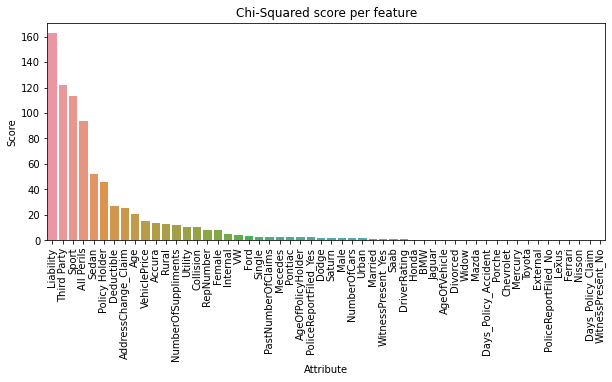

In [60]:
fig = plt.figure(figsize = (10, 4))
ax = sns.barplot(x='Attribute', y='Score', data=df_score)
plt.xticks(rotation=90);
ax.set_title('Chi-Squared score per feature');

At first, we choose those attributes which the score was higher than 15.

In [61]:
final_cols = []
c = 0
for value in df_score['Score'].values:
    if value > 15:
        final_cols.append(df_score.iloc[c, 0])
        c += 1
        
print(final_cols, '\n')
print(len(final_cols))

['Liability', 'Third Party', 'Sport', 'All Perils', 'Sedan', 'Policy Holder', 'Deductible', 'AddressChange_Claim', 'Age', 'VehiclePrice'] 

10


With the selected features, we proceed to transform the *X_train* into a dataset, necessary for future balancing:

In [62]:
df_final.drop('FraudFound_P', axis = 1, inplace = True)
x_train_df = pd.DataFrame(X_train, columns = df_final.columns)
x_train_df.head()

,Age,RepNumber,Deductible,DriverRating,Accura,BMW,Chevrolet,Dodge,Ferrari,Ford,...,Liability,VehiclePrice,AgeOfVehicle,AgeOfPolicyHolder,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,NumberOfSuppliments,AddressChange_Claim,NumberOfCars
0,26.0,4.0,400.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,6.0,3.0,4.0,2.0,3.0,1.0,4.0,1.0
1,51.0,5.0,400.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,6.0,5.0,4.0,2.0,3.0,0.0,0.0,0.0
2,55.0,2.0,400.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,7.0,5.0,4.0,2.0,1.0,3.0,0.0,0.0
3,33.0,8.0,400.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,3.0,4.0,2.0,3.0,0.0,0.0,0.0
4,42.0,3.0,400.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,6.0,4.0,4.0,2.0,2.0,3.0,0.0,0.0


Then, we merge the *y_train* dataset on the *X_train* values to create a final dataset for balancing and model training:

In [63]:
train_df = x_train_df.loc[:,final_cols]
train_df['FraudFound_P'] = y_train
train_df.head()

,Liability,Third Party,Sport,All Perils,Sedan,Policy Holder,Deductible,AddressChange_Claim,Age,VehiclePrice,FraudFound_P
0,1.0,0.0,1.0,0.0,0.0,1.0,400.0,4.0,26.0,2.0,0
1,0.0,0.0,0.0,0.0,1.0,1.0,400.0,0.0,51.0,1.0,0
2,0.0,1.0,0.0,1.0,1.0,0.0,400.0,0.0,55.0,1.0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,400.0,0.0,33.0,1.0,0
4,0.0,0.0,0.0,0.0,1.0,1.0,400.0,0.0,42.0,1.0,0


The feature selection continues with the proper training dataset. On the next step, we analyse the correlation between the selected features to avoid inputing redundancy on the model:

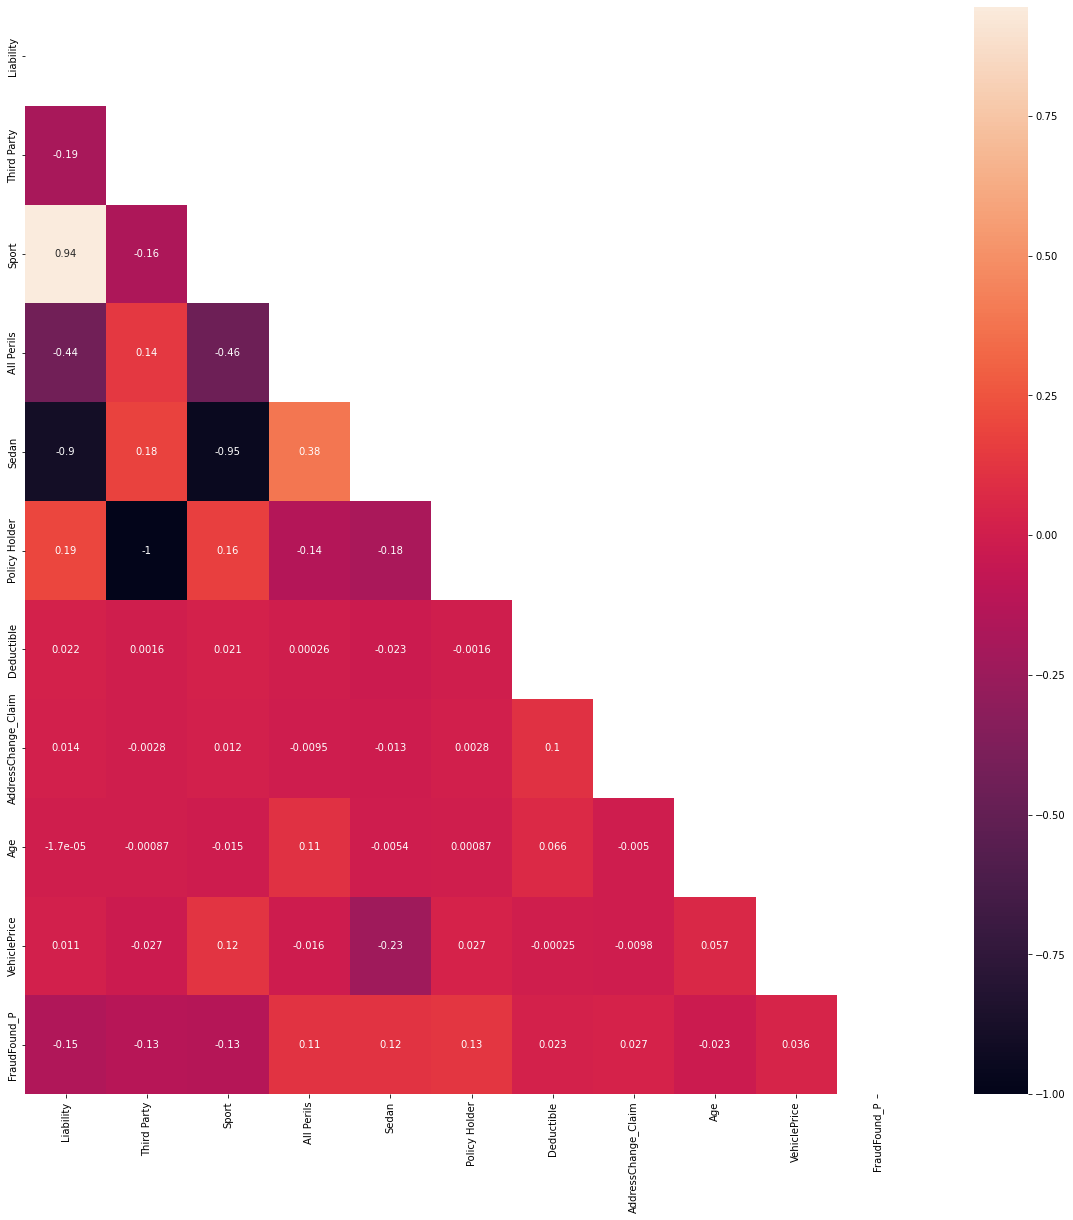

In [64]:
plt.figure(figsize=(20, 20))

corr = train_df.corr(method = 'pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask = mask,annot = True);

In [65]:
c = []
for row in corr.index:
    for column in corr.columns:
        
        if abs(corr.loc[row, column]) >= 0.8 and row != column:
            print(f'{row} | {column}.')

            if corr.loc[row, 'FraudFound_P'] < 0:
                c.append(row)

Liability | Sport.
Liability | Sedan.
Third Party | Policy Holder.
Sport | Liability.
Sport | Sedan.
Sedan | Liability.
Sedan | Sport.
Policy Holder | Third Party.


As we can see, some features presented an absolute correlation higher than the 0.8 cut-off so, in order to finish the feature selection, we remove it from the data:

In [66]:
final_cols.remove('Liability')
final_cols.remove('Third Party')
final_cols.remove('Sport')
final_cols

['All Perils',
 'Sedan',
 'Policy Holder',
 'Deductible',
 'AddressChange_Claim',
 'Age',
 'VehiclePrice']

Then, we proceed with the following dataset:

In [67]:
train_df = train_df[final_cols].copy()
train_df['FraudFound_P'] = y_train
train_df.head()

,All Perils,Sedan,Policy Holder,Deductible,AddressChange_Claim,Age,VehiclePrice,FraudFound_P
0,0.0,0.0,1.0,400.0,4.0,26.0,2.0,0
1,0.0,1.0,1.0,400.0,0.0,51.0,1.0,0
2,1.0,1.0,0.0,400.0,0.0,55.0,1.0,0
3,0.0,1.0,0.0,400.0,0.0,33.0,1.0,0
4,0.0,1.0,1.0,400.0,0.0,42.0,1.0,0


In [68]:
train_df.shape

(10570, 8)

In [69]:
train_df.tail()

,All Perils,Sedan,Policy Holder,Deductible,AddressChange_Claim,Age,VehiclePrice,FraudFound_P
10565,1.0,1.0,1.0,400.0,0.0,44.0,1.0,1
10566,0.0,1.0,0.0,400.0,0.0,55.0,1.0,0
10567,1.0,1.0,0.0,400.0,0.0,58.0,0.0,0
10568,0.0,1.0,1.0,400.0,0.0,26.0,1.0,0
10569,0.0,1.0,1.0,400.0,0.0,33.0,1.0,0


After the preparation of the training data is done, we proceed to adjust the test data as well:

In [70]:
# Creating the test dataset with the columns selected during the feature selection

test_df = pd.DataFrame(X_test, columns = df_final.columns)
test_df = test_df.loc[:,final_cols]
test_df['FraudFound_P'] = y_test
test_df.head()

,All Perils,Sedan,Policy Holder,Deductible,AddressChange_Claim,Age,VehiclePrice,FraudFound_P
0,0.0,1.0,0.0,400.0,0.0,42.0,1.0,0
1,1.0,0.0,1.0,400.0,0.0,43.0,5.0,0
2,0.0,0.0,1.0,400.0,0.0,48.0,2.0,0
3,0.0,0.0,1.0,400.0,4.0,54.0,1.0,0
4,0.0,0.0,1.0,400.0,0.0,28.0,1.0,0


In [71]:
test_df.shape

(4530, 8)

With all  features properly prepared and selected, we can proceed to the next project phase, where we balance the training data so the models do not incur on bias.

### 7. Balancing

Since the "Fraud" value for the target variable has low occurence when compared with "Not Fraud", we must balance the data to train the models. There are numerous methods to balance an imbalanced dataset but, on this project, we will deploy three strategies: Oversampling, Undersampling and a combination of Oversampling and Undersampling. On Oversampling we simulate the samples of the minority class until the dataset becomes balanced through Synthetic Minority Oversampling Technique (SMOTE), on Undersampling we deploy the Cluster Centroid method and, for the combination of oversampling and undersampling, we deploy a combination of SMOTE and Edited Nearest Neighbor (SMOTEENN).

In [72]:
# Displaying the ocurrence of each category

print(train_df['FraudFound_P'].value_counts())

0    9945
1     625
Name: FraudFound_P, dtype: int64


In [73]:
# Spliting train_df

X_train = train_df.iloc[:,:-1].values
y_train = train_df.iloc[:,-1].values

#### 7.1 Oversampling

In [74]:
sm = SMOTE(random_state=seed)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
y_sm_list = list(y_sm)
print(y_sm_list.count(0))
print(y_sm_list.count(1))

9945
9945


#### 7.2 Undersampling

In [75]:
cc = ClusterCentroids(random_state=seed)
X_cc, y_cc = cc.fit_resample(X_train, y_train)
y_cc_list = list(y_cc)
print(y_cc_list.count(0))
print(y_cc_list.count(1))

625
625


#### 7.3 Oversampling + Undersampling

In [76]:
n_m = 0.5 * train_df['FraudFound_P'].value_counts()[0]      # number of samples in minority class
n_rm = train_df['FraudFound_P'].value_counts()[0]           # number of samples in majority class after resampling
alpha = round(n_m/n_rm, 2)
alpha

0.5

In [77]:
smote = SMOTE(sampling_strategy = alpha)
enn = EditedNearestNeighbours(n_neighbors = 3, sampling_strategy = 'majority')
sme = SMOTEENN(random_state=seed, smote = smote, enn = enn)

In [78]:
X_smte, y_smte = sme.fit_resample(X_train, y_train)

In [79]:
y_smte_list = list(y_smte)
print(f'Numer of no frauds sample: {y_smte_list.count(0)}')
print(f'Numer of frauds sample: {y_smte_list.count(1)}')

Numer of no frauds sample: 8296
Numer of frauds sample: 4972


### 8. Modelling

On the next section, we develop the models for all three datasets, with oversampling, undersampling and both oversampling and undersampling.
We begin with oversampled data:

#### 8.1 Oversampled data

##### 8.1.1 Test Design

Now, we will transform our train and test data into arrays so the models can learn and predict from it. The $X$ values are related to the attributes selected during the feature selection and the $y$ values are related to the _FraudFound_P_ values.

In [80]:
# Spliting the test data between X and y

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

##### 8.1.2 Building Models

With both $X$ and $y$ data for train and test set, we proceed to build the models. On this project we selected five models, which are: Light Gradient Boosting Machine (LGBM), Extreme Gradient Boosting (XGBoost), K-Nearest Neighbors (KNN), Support Vector Machine (SVM) and Random Forest.
For all the models, we proceed to run a hyperparameter tuning and, after it selects the optimum values, we run the models with it.

They are built through the code blocks below:

###### LGBM

In [81]:
params =[
    {
        'num_leaves': [50, 100, 200],
        'max_depth': [6, 9, 12],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 150],
        'min_gain_to_split' : [0, 5, 15]
    }
]
opt_params = GridSearchCV(
    LGBMClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_sm, y_sm)
opt_params.best_params_

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


{'learning_rate': 0.3,
 'max_depth': 9,
 'min_gain_to_split': 0,
 'n_estimators': 100,
 'num_leaves': 50}

In [82]:
lgbm_o = LGBMClassifier(learning_rate=0.3, max_depth=9, min_gain_to_split=0, n_estimators=100, num_leaves=50, random_state=seed)
lgbm_o.fit(X_sm, y_sm)
pred_lgbm_o = lgbm_o.predict(X_test)

##### XGBoost

In [83]:
params =[
    {
        'eta': [0.3, 0.1, 0.01],
        'n_estimators': [50, 150, 300],
        'gamma' : [0, 5, 10],
        'max_depth' : [3, 6, 9, 12],
        'min_child_weight' : [0, 6, 12]
    }
]
opt_params = GridSearchCV(
    XGBClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_sm, y_sm)
opt_params.best_params_

{'eta': 0.3,
 'gamma': 0,
 'max_depth': 9,
 'min_child_weight': 0,
 'n_estimators': 150}

In [84]:
xgb_o = XGBClassifier(eta=0.3, gamma=0, max_depth=9, min_child_weight=0, n_estimators=150, random_state = seed)
xgb_o.fit(X_sm, y_sm)
pred_xgb_o = xgb_o.predict(X_test)

##### KNN

In [85]:
params = [
    {
        'n_neighbors': [1,2,3,4,5],
        'weights': ['uniform', 'distance']
    }
]
opt_params = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_sm, y_sm)
opt_params.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [86]:
knn_o = KNeighborsClassifier(n_neighbors=1, weights = 'uniform')
knn_o.fit(X_sm, y_sm)
pred_knn_o = knn_o.predict(X_test)

##### SVM

In [87]:
params = [
    {
        'C': [0.5, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
]

optimal_params = GridSearchCV(
    SVC(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_sm, y_sm)
optimal_params.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [88]:
svm_o = SVC(C=100, gamma=1, random_state = seed, probability = True)
svm_o.fit(X_sm, y_sm)
pred_svm_o = svm_o.predict(X_test)

##### Random Forest

In [89]:
params = [
    {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 50, 100, 150]
    }
]

optimal_params = GridSearchCV(
    RandomForestClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_sm, y_sm)
optimal_params.best_params_

{'max_depth': 50, 'n_estimators': 300}

In [90]:
rf_o = RandomForestClassifier(max_depth=50, n_estimators=200, random_state = seed)
rf_o.fit(X_sm, y_sm)
pred_rf_o = rf_o.predict(X_test)

##### Logistic Regression

In [91]:
params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l2'],
        'C': [10, 1, 0.1, 0.01]
    }
]

optimal_params = GridSearchCV(
    LogisticRegression(max_iter=400),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_sm, y_sm)
optimal_params.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [92]:
lr_o = LogisticRegression(solver='liblinear', penalty = 'l2', C = 10, max_iter=400)
lr_o.fit(X_train, y_train)
pred_lr_o = lr_o.predict(X_test)

#### 8.2 Undersampled data

##### 8.2.1 Building Models

##### LGBM

In [93]:
params =[
    {
        'num_leaves': [50, 100, 200],
        'max_depth': [6, 9, 12],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 150],
        'min_gain_to_split' : [0, 5, 15]
    }
]
opt_params = GridSearchCV(
    LGBMClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_cc, y_cc)
opt_params.best_params_

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


{'learning_rate': 0.1,
 'max_depth': 6,
 'min_gain_to_split': 0,
 'n_estimators': 100,
 'num_leaves': 50}

In [96]:
lgbm_u = LGBMClassifier(learning_rate=0.1, max_depth=6, min_gain_to_split=0, n_estimators=100, num_leaves=50, random_state=seed)
lgbm_u.fit(X_cc, y_cc)
pred_lgbm_u = lgbm_u.predict(X_test)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


##### XGBoost

In [97]:
params =[
    {
        'eta': [0.3, 0.1, 0.01],
        'n_estimators': [50, 150, 300],
        'gamma' : [0, 5, 10],
        'max_depth' : [3, 6, 9, 12],
        'min_child_weight' : [0, 6, 12]
    }
]
opt_params = GridSearchCV(
    XGBClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_cc, y_cc)
opt_params.best_params_

{'eta': 0.1,
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 0,
 'n_estimators': 300}

In [98]:
xgb_u = XGBClassifier(eta=0.1, gamma=0, max_depth=3, min_child_weight=0, n_estimators=300, random_state = seed)
xgb_u.fit(X_cc, y_cc)
pred_xgb_u = xgb_u.predict(X_test)

##### KNN

In [99]:
params = [
    {
        'n_neighbors': [1,2,3,4,5],
        'weights': ['uniform', 'distance']
    }
]
opt_params = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_cc, y_cc)
opt_params.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

In [100]:
knn_u = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')
knn_u.fit(X_cc, y_cc)
pred_knn_u = knn_u.predict(X_test)

##### SVM

In [101]:
params = [
    {
        'C': [0.5, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
]

optimal_params = GridSearchCV(
    SVC(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_cc, y_cc)
optimal_params.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [102]:
svm_u = SVC(C=100, gamma=.01, random_state = seed, probability = True)
svm_u.fit(X_cc, y_cc)
pred_svm_u = svm_u.predict(X_test)

##### Random Forest

In [225]:
params = [
    {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 50, 100, 150]
    }
]

optimal_params = GridSearchCV(
    RandomForestClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_cc, y_cc)
optimal_params.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [226]:
rf_u = RandomForestClassifier(max_depth=10, n_estimators=100, random_state = seed)
rf_u.fit(X_cc, y_cc)
pred_rf_u = rf_u.predict(X_test)

##### Logistic Regression

In [105]:
params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l2'],
        'C': [10, 1, 0.1, 0.01]
    }
]

optimal_params = GridSearchCV(
    LogisticRegression(max_iter=400),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_cc, y_cc)
optimal_params.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [106]:
lr_u = LogisticRegression(solver='liblinear', penalty = 'l2', C = 10, max_iter=400)
lr_u.fit(X_cc, y_cc)
pred_lr_u = lr_u.predict(X_test)

#### 8.3 Oversampled+undersampled data with SMOTEENN

##### 8.3.1 Building Models

##### LGBM

In [107]:
params =[
    {
        'num_leaves': [50, 100, 200],
        'max_depth': [6, 9, 12],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 150],
        'min_gain_to_split' : [0, 5, 15]
    }
]
opt_params = GridSearchCV(
    LGBMClassifier(class_weight='balanced'),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_smte, y_smte)
opt_params.best_params_

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


{'learning_rate': 0.3,
 'max_depth': 12,
 'min_gain_to_split': 0,
 'n_estimators': 100,
 'num_leaves': 100}

In [108]:
lgbm_b = LGBMClassifier(learning_rate=0.3, 
                      max_depth=12, 
                      min_gain_to_split=0, 
                      n_estimators=100, 
                      num_leaves=100, 
                      random_state=seed, 
                      class_weight='balanced',
                      objective = 'binary')
lgbm_b.fit(X_smte, y_smte)
pred_lgbm_b = lgbm_b.predict(X_test)

##### XGBoost

In [109]:
params =[
    {
        'eta': [0.3, 0.1, 0.01],
        'n_estimators': [50, 150, 300],
        'gamma' : [0, 5, 10],
        'max_depth' : [3, 6, 9, 12],
        'min_child_weight' : [0, 6, 12]
    }
]
opt_params = GridSearchCV(
    XGBClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_smte, y_smte)
opt_params.best_params_

{'eta': 0.3,
 'gamma': 0,
 'max_depth': 12,
 'min_child_weight': 0,
 'n_estimators': 150}

In [110]:
xgb_b = XGBClassifier(eta=0.3, gamma=0, max_depth=12, min_child_weight=0, n_estimators=150, random_state = seed)
xgb_b.fit(X_smte, y_smte)
pred_xgb_b = xgb_b.predict(X_test)

##### KNN

In [111]:
params = [
    {
        'n_neighbors': [1,2,3,4,5],
        'weights': ['uniform', 'distance']
    }
]
opt_params = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
opt_params.fit(X_smte, y_smte)
opt_params.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [112]:
knn_b = KNeighborsClassifier(n_neighbors=1, weights = 'uniform')
knn_b.fit(X_smte, y_smte)
pred_knn_b = knn_b.predict(X_test)

##### SVM

In [113]:
params = [
    {
        'C': [0.5, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
]

optimal_params = GridSearchCV(
    SVC(class_weight='balanced'),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_smte, y_smte)
optimal_params.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [114]:
svm_b = SVC(C=100, gamma=1, random_state = seed, probability = True, class_weight='balanced')
svm_b.fit(X_train, y_train)
pred_svm_b = svm_b.predict(X_test)

##### Random Forest

In [115]:
params = [
    {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 50, 100, 150]
    }
]

optimal_params = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_smte, y_smte)
optimal_params.best_params_

{'max_depth': 150, 'n_estimators': 300}

In [116]:
rf_b = RandomForestClassifier(max_depth=150, n_estimators=300, random_state = seed, class_weight='balanced')
rf_b.fit(X_smte, y_smte)
pred_rf_b = rf_b.predict(X_test)

##### Logistic Regression

In [117]:
params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l2'],
        'C': [10, 1, 0.1, 0.01]
    }
]

optimal_params = GridSearchCV(
    LogisticRegression(max_iter=400),
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

optimal_params.fit(X_smte, y_smte)
optimal_params.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [118]:
lr_b = LogisticRegression(solver='liblinear', class_weight='balanced', penalty = 'l2', C = 10, max_iter=300)
lr_b.fit(X_smte, y_smte)
pred_lr_b = lr_b.predict(X_test)

##### 8.4 Assessing the models

At this step, we look for the models' performance. First we develop a function that return the models with the best three models with the highest F1 scores for each dataset.
For each tuned model, the following code displays F1 Score metrics:

In [119]:
# Defining a function to return the best results:

'''
Calculate the F1 score for each model and return the best results.
'''

def best_results(models):
    results_o = pd.DataFrame()
    results_u = pd.DataFrame()
    results_b = pd.DataFrame()

    for model, pred_o, pred_u, pred_b in models:
        x = error_tab(model, y_test, pred_o.predict(X_test))
        y = error_tab(model, y_test, pred_u.predict(X_test))
        z = error_tab(model, y_test, pred_b.predict(X_test))
        
        results_o = pd.concat([results_o,x])
        results_u = pd.concat([results_u,y])
        results_b = pd.concat([results_b,z])
        results = results_o.merge(results_u, on='Model Name', suffixes = ('_o', '_u')).merge(results_b, on='Model Name'). rename(columns={'Accuracy Score': 'Accuracy Score_b', 'F1 Score': 'F1 Score_b'})
        
        top_3_o = results.nlargest(3,'F1 Score_o').iloc[:,[0,2]].to_string(index=False)
        top_3_u = results.nlargest(3,'F1 Score_u').iloc[:,[0,4]].to_string(index=False)
        top_3_b = results.nlargest(3,'F1 Score_b').iloc[:,[0,6]].to_string(index=False)
        
    print('Top 3 Models (oversampled):' + '\n' + top_3_o + '\n')
    print('Top 3 Models (undersampled):' + '\n' + top_3_u + '\n')
    print('Top 3 Models (oversampled + undersampled):' + '\n' + top_3_b)        

In [227]:
models = [
    ['LGBM', lgbm_o, lgbm_u, lgbm_b],
    ['XGBoost', xgb_o, xgb_u, xgb_b],
    ['KNN', knn_o, knn_u, knn_b],
    ['SVM', svm_o, svm_u, svm_b],
    ['Random Forest', rf_o, rf_u, rf_b],
    ['Logistic Regression', lr_o, lr_u, lr_b]
]

best_results(models)

Top 3 Models (oversampled):
   Model Name  F1 Score_o
         LGBM    0.205630
Random Forest    0.204327
      XGBoost    0.201970

Top 3 Models (undersampled):
         Model Name  F1 Score_u
Logistic Regression    0.224432
                SVM    0.215044
      Random Forest    0.184442

Top 3 Models (oversampled + undersampled):
         Model Name  F1 Score_b
Logistic Regression    0.216340
               LGBM    0.206504
      Random Forest    0.203673


### 9. Ensemble

With the result from the previous section, we will use the three best models (i.e, with highest f1-score) for each dataset and create an ensemble using __VotingClassifier__.

#### 9.1 Oversampled Models

In [228]:
estimators_o = [('lgbm', lgbm_o), ('xgb', xgb_o), ('rf', rf_o)]
ensemble_o = VotingClassifier(estimators = estimators_o, voting = 'soft')
ensemble_o.fit(X_sm, y_sm)
pred_ensemble_o = ensemble_o.predict(X_test)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


In [229]:
print(classification_report(y_test, pred_ensemble_o))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      4263
           1       0.15      0.32      0.21       267

    accuracy                           0.86      4530
   macro avg       0.55      0.60      0.56      4530
weighted avg       0.91      0.86      0.88      4530



#### 9.2 Undersampled Models

In [230]:
estimators_u = [('lr', lr_u), ('svm', svm_u), ('rf', rf_u)]
ensemble_u = VotingClassifier(estimators = estimators_u, voting = 'soft')
ensemble_u.fit(X_cc, y_cc)
pred_ensemble_u = ensemble_u.predict(X_test)

In [231]:
print(classification_report(y_test, pred_ensemble_u))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      4263
           1       0.12      0.95      0.22       267

    accuracy                           0.60      4530
   macro avg       0.56      0.76      0.47      4530
weighted avg       0.94      0.60      0.70      4530



#### 9.3 Under + Oversampled Models

In [205]:
estimators_b = [('lr', lr_u), ('rf', rf_b), ('lgbm', lgbm_b)]
ensemble_b = VotingClassifier(estimators = estimators_b, voting = 'soft')
ensemble_b.fit(X_smte, y_smte)
pred_ensemble_b = ensemble_b.predict(X_test)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


In [206]:
print(classification_report(y_test, pred_ensemble_b))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      4263
           1       0.13      0.49      0.21       267

    accuracy                           0.78      4530
   macro avg       0.55      0.65      0.54      4530
weighted avg       0.91      0.78      0.83      4530



### 10. Evaluation

After building all models, we proceed to the Evaluation phase, were we evaluate the final results to determine which model displayed the best performance.
Our analysis begin with the confusion matrices for the models with the best f1 scores and the ensemble models, so we can see their True Positives (TP), False Positives (FP), True Negatives (TN) and False Negatives (FN):

#### 10.1 Confusion Matrices

##### 10.1.1 Oversampled models

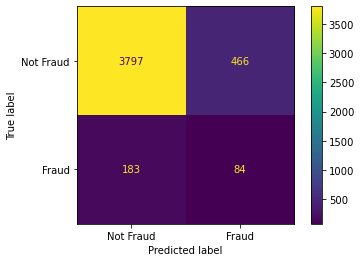

In [127]:
ConfusionMatrixDisplay.from_estimator(lgbm_o,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

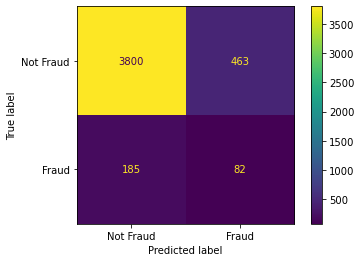

In [128]:
ConfusionMatrixDisplay.from_estimator(xgb_o,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

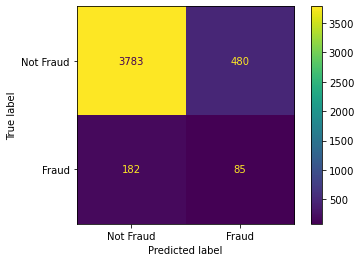

In [129]:
ConfusionMatrixDisplay.from_estimator(rf_o,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

##### 10.1.2 Undersampled models

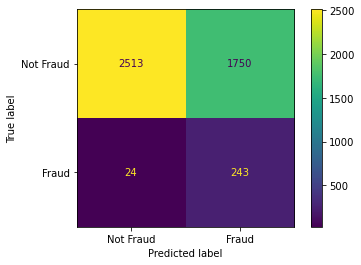

In [130]:
ConfusionMatrixDisplay.from_estimator(svm_u,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

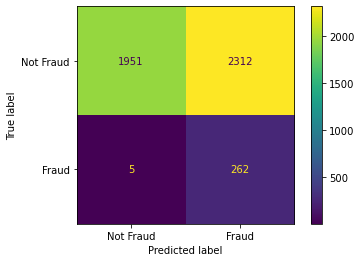

In [232]:
ConfusionMatrixDisplay.from_estimator(rf_u,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

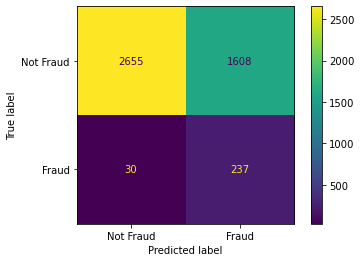

In [132]:
ConfusionMatrixDisplay.from_estimator(lr_u,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

##### 10.1.3 Oversampled and Undersampled models

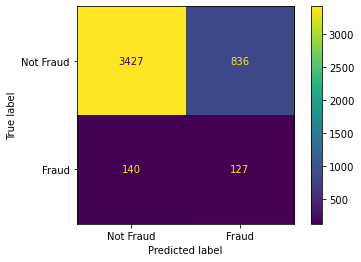

In [133]:
ConfusionMatrixDisplay.from_estimator(lgbm_b,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

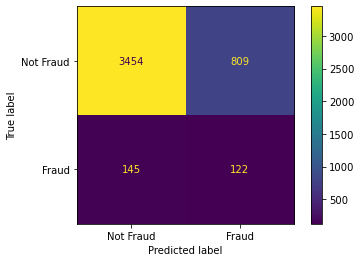

In [134]:
ConfusionMatrixDisplay.from_estimator(rf_b,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

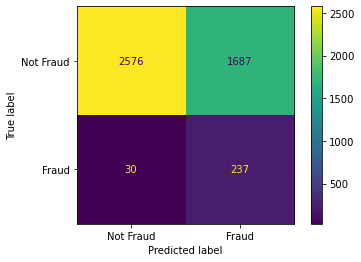

In [135]:
ConfusionMatrixDisplay.from_estimator(lr_b,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

##### 10.1.4 Ensemble models

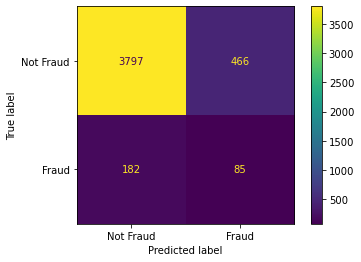

In [208]:
ConfusionMatrixDisplay.from_estimator(ensemble_o,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

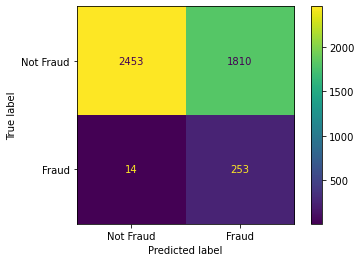

In [233]:
ConfusionMatrixDisplay.from_estimator(ensemble_u,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

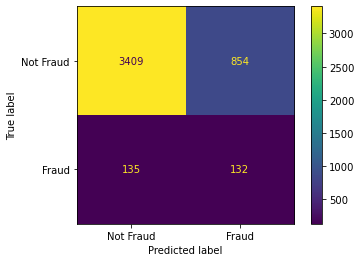

In [210]:
ConfusionMatrixDisplay.from_estimator(ensemble_b,
                                      X_test,
                                      y_test,
                                     display_labels=['Not Fraud', 'Fraud']
                                     )

#### 10.2 ROC Curve

At last, we display the ROC (Receiver Operating Characteristic) curve and the AUC (Area Under the Curve) scores for all developed models below:

##### 10.2.1 ROC Curve (oversampled)

In [139]:
#creating the line where true positive rate = false positive rate
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# ROC for XGBoost
xgb_probs = xgb_o.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# ROC for SVM
svm_probs = svm_o.predict_proba(X_test)
svm_probs = svm_probs[:, 1]
svm_auc = roc_auc_score(y_test, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

# ROC for knn
knn_probs = knn_o.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
knn_auc = roc_auc_score(y_test, knn_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)

# ROC for rfr
rf_probs = rf_o.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# ROC for lgbm
lgbm_probs = lgbm_o.predict_proba(X_test)
lgbm_probs = lgbm_probs[:, 1]
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)

# ROC for Logistic Regression
lr_probs = lr_o.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)


print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))
print('RFR: ROC AUC=%.3f' % (rf_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.781
SVM: ROC AUC=0.681
KNN: ROC AUC=0.549
RFR: ROC AUC=0.724
LGBM: ROC AUC=0.780
Logistic Regression: ROC AUC=0.790


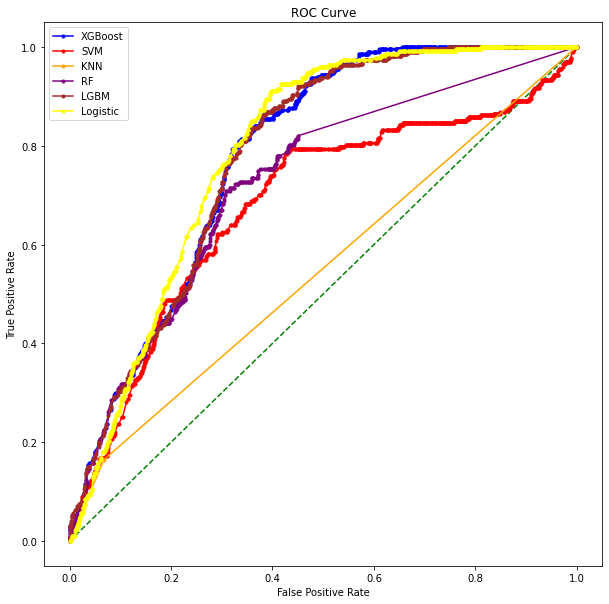

In [140]:
plt.figure(figsize=(10, 10))

plt.plot(ns_fpr, ns_tpr, linestyle='--', color = 'green')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost', color = 'blue')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM', color = 'red')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN', color = 'orange')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF', color = 'purple')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM', color = 'brown')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', color = 'yellow')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

##### 10.2.2 ROC Curve (undersampled)

In [234]:
#creating the line where true positive rate = false positive rate
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# ROC for XGBoost
xgb_probs = xgb_u.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# ROC for SVM
svm_probs = svm_u.predict_proba(X_test)
svm_probs = svm_probs[:, 1]
svm_auc = roc_auc_score(y_test, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

# ROC for knn
knn_probs = knn_u.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
knn_auc = roc_auc_score(y_test, knn_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)

# ROC for rfr
rf_probs = rf_u.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# ROC for lgbm
lgbm_probs = lgbm_u.predict_proba(X_test)
lgbm_probs = lgbm_probs[:, 1]
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)

# ROC for Logistic Regression
lr_probs = lr_u.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)


print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))
print('RFR: ROC AUC=%.3f' % (rf_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.768
SVM: ROC AUC=0.788
KNN: ROC AUC=0.663
RFR: ROC AUC=0.792
LGBM: ROC AUC=0.746
Logistic Regression: ROC AUC=0.772


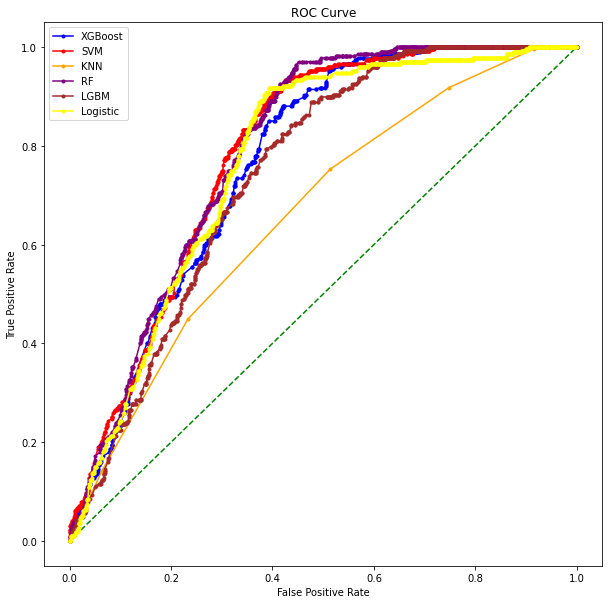

In [235]:
plt.figure(figsize=(10, 10))

plt.plot(ns_fpr, ns_tpr, linestyle='--', color = 'green')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost', color = 'blue')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM', color = 'red')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN', color = 'orange')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF', color = 'purple')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM', color = 'brown')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', color = 'yellow')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

##### 10.2.3 ROC Curve (oversampled + undersampled)

In [213]:
#creating the line where true positive rate = false positive rate
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# ROC for XGBoost
xgb_probs = xgb_b.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# ROC for SVM
svm_probs = svm_b.predict_proba(X_test)
svm_probs = svm_probs[:, 1]
svm_auc = roc_auc_score(y_test, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

# ROC for knn
knn_probs = knn_b.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
knn_auc = roc_auc_score(y_test, knn_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)

# ROC for rfr
rf_probs = rf_b.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# ROC for lgbm
lgbm_probs = lgbm_b.predict_proba(X_test)
lgbm_probs = lgbm_probs[:, 1]
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)

# ROC for Logistic Regression
lr_probs = lr_b.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)


print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))
print('RFR: ROC AUC=%.3f' % (rf_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.777
SVM: ROC AUC=0.687
KNN: ROC AUC=0.610
RFR: ROC AUC=0.732
LGBM: ROC AUC=0.766
Logistic Regression: ROC AUC=0.783


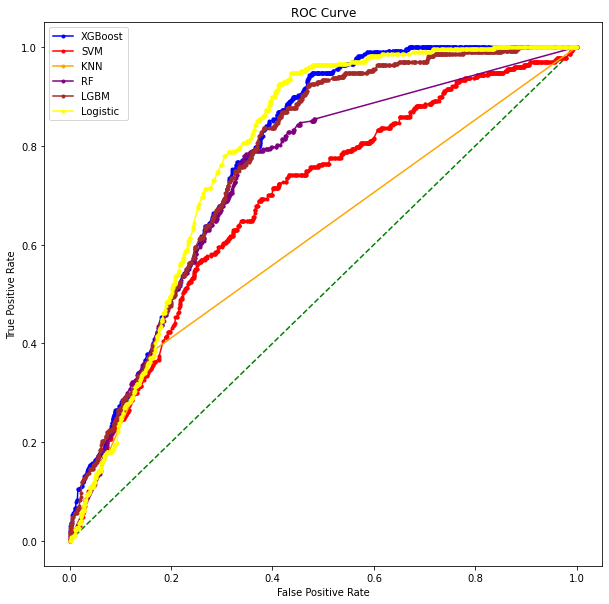

In [214]:
plt.figure(figsize=(10, 10))

plt.plot(ns_fpr, ns_tpr, linestyle='--', color = 'green')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost', color = 'blue')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM', color = 'red')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN', color = 'orange')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF', color = 'purple')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM', color = 'brown')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', color = 'yellow')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

##### 10.2.4 ROC Curve (Ensemble models)

In [236]:
#creating the line where true positive rate = false positive rate
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# ROC for Ensemble (oversampled)
en_o_probs = ensemble_o.predict_proba(X_test)
en_o_probs = en_o_probs[:, 1]
en_o_auc = roc_auc_score(y_test, en_o_probs)
en_o_fpr, en_o_tpr, _ = roc_curve(y_test, en_o_probs)

# ROC for SVM
en_u_probs = ensemble_u.predict_proba(X_test)
en_u_probs = en_u_probs[:, 1]
en_u_auc = roc_auc_score(y_test, en_u_probs)
en_u_fpr, en_u_tpr, _ = roc_curve(y_test, en_u_probs)

# ROC for knn
en_b_probs = ensemble_b.predict_proba(X_test)
en_b_probs = en_b_probs[:, 1]
en_b_auc = roc_auc_score(y_test, en_b_probs)
en_b_fpr, en_b_tpr, _ = roc_curve(y_test, en_b_probs)



print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Ensemble (oversampled): ROC AUC=%.3f' % (en_o_auc))
print('Ensemble (undersampled): ROC AUC=%.3f' % (en_u_auc))
print('Ensemble (over + under): ROC AUC=%.3f' % (en_b_auc))

No Skill: ROC AUC=0.500
Ensemble (oversampled): ROC AUC=0.780
Ensemble (undersampled): ROC AUC=0.787
Ensemble (over + under): ROC AUC=0.780


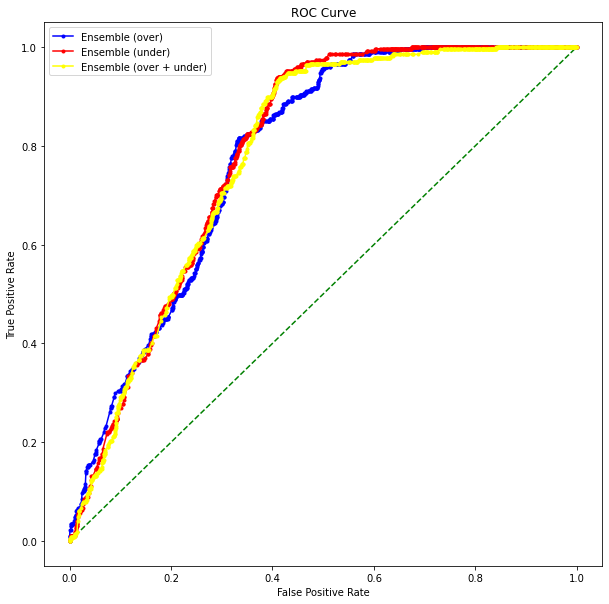

In [237]:
plt.figure(figsize=(10, 10))

plt.plot(ns_fpr, ns_tpr, linestyle='--', color = 'green')
plt.plot(en_o_fpr, en_o_tpr, marker='.', label='Ensemble (over)', color = 'blue')
plt.plot(en_u_fpr, en_u_tpr, marker='.', label='Ensemble (under)', color = 'red')
plt.plot(en_b_fpr, en_b_tpr, marker='.', label='Ensemble (over + under)', color = 'yellow')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

Through these results, we can see that the developed models (with exception of KNN) achieved a good True Positive Rate (TPR) and that the top 3 F1 score models and ensemble models achieved an AUC score above 0.7, which points to a good performance.

With all presented results, we decide to use the Random Forest with undersampled data, since it has a good AUC score (0.79) and incur on low Type II error, were a 'Fraud' is incorrectly classified as 'Not Fraud'. 
Since only 5 cases were False Negative (FN), we proceed to analyse if they are outliers.

### 11. Outlier detection

On this step, we proceed to analyse the selected model to check if the frauds that were not detected are outliers.
We start with the data preparation for the Isolation Forest and K-Means models:

In [238]:
data = pd.DataFrame(X_test)
data1 = pd.DataFrame(pred_rf_u)
data1.rename(columns = {0 : 'pred_rf_u'}, inplace = True)
data2 = pd.DataFrame(y_test)
data2.rename(columns = {0 : 'y_test'}, inplace = True)
data3 = pd.concat([data2, data1, data], axis = 1)

data3.head()

,y_test,pred_rf_u,0,1,2,3,4,5,6
0,0,0,0.0,1.0,0.0,400.0,0.0,42.0,1.0
1,0,1,1.0,0.0,1.0,400.0,0.0,43.0,5.0
2,0,0,0.0,0.0,1.0,400.0,0.0,48.0,2.0
3,0,0,0.0,0.0,1.0,400.0,4.0,54.0,1.0
4,0,1,0.0,0.0,1.0,400.0,0.0,28.0,1.0


In [239]:
final = data3[data3['pred_rf_u'] == 0].reset_index()
final.drop('index', axis = 1, inplace = True)
final.head()

,y_test,pred_rf_u,0,1,2,3,4,5,6
0,0,0,0.0,1.0,0.0,400.0,0.0,42.0,1.0
1,0,0,0.0,0.0,1.0,400.0,0.0,48.0,2.0
2,0,0,0.0,0.0,1.0,400.0,4.0,54.0,1.0
3,0,0,0.0,0.0,1.0,400.0,0.0,57.0,2.0
4,0,0,1.0,1.0,0.0,400.0,0.0,27.0,2.0


In [240]:
X_final = final.iloc[:, 2:].values
y_final = final.iloc[:, 0].values

With the datasets for the target variable ($y$) and the predictor variables ($X$) ready, we proceed to the model application.
First, we apply an Isolation Forest:

#### 11.1 Isolation Forest

In [241]:
iforest = IsolationForest(n_estimators=100,max_samples=100,contamination=float(0.1),random_state=seed, max_features=6, bootstrap=True)
iforest.fit(X_final)
iforest_scores = pd.DataFrame(iforest.decision_function(X_final))
iforest_anomaly_score = pd.DataFrame(iforest.predict(X_final))
iforest_final = final.copy()
iforest_final['scores'] = iforest_scores
iforest_final['anomaly_score'] = iforest_anomaly_score

iforest_final[iforest_final['anomaly_score']==-1].head()

,y_test,pred_rf_u,0,1,2,3,4,5,6,scores,anomaly_score
2,0,0,0.0,0.0,1.0,400.0,4.0,54.0,1.0,-0.021431,-1
7,0,0,0.0,1.0,0.0,400.0,4.0,28.0,0.0,-0.041577,-1
24,0,0,0.0,1.0,0.0,400.0,4.0,42.0,0.0,-0.037598,-1
37,0,0,0.0,0.0,1.0,500.0,3.0,48.0,2.0,-0.044348,-1
64,0,0,0.0,0.0,1.0,700.0,0.0,33.0,2.0,-0.014162,-1


In [242]:
iforest_final[iforest_final['anomaly_score']==-1]['y_test'].value_counts()

0    193
1      1
Name: y_test, dtype: int64

As can be seen, only one outlier represent a fraudulent claim.

#### 11.2 K-means

First, we will calculate the ideal number of clusters for our dataset. To do that, we will use two methods: the Elbow method (we need to calculate the average distances to the centroid and, then, plot these points and find where the average distance falls suddenly) and the silhouette coefficient (it is a measure of how similir a data point is in relation to one cluster to another, closer to 1, more coherent that point is).

But step zero is making the PCA (Principal Component Analysis), since our data set have six independent variables and we need to reduce it to two, in order to observe the data through scatter plot. As we want to treat every equally (i.e. their values fall within the same numerical range), we need to make a standardization process, so, we apply __StandardScaler__.

In [243]:
pca = PCA(n_components=2)
x = StandardScaler().fit_transform(X_final)
principalComponents = pca.fit_transform(x)

We will now create a DataFrame with the standardized values of component1 and component2

In [244]:
principal_Df = pd.DataFrame(data = principalComponents
             , columns = ['component1', 'component2'])
principal_Df.tail()

,component1,component2
1951,1.781639,-0.683241
1952,0.449502,-0.432029
1953,1.660242,-0.574137
1954,-2.077835,-0.013470
1955,1.502011,-0.638769


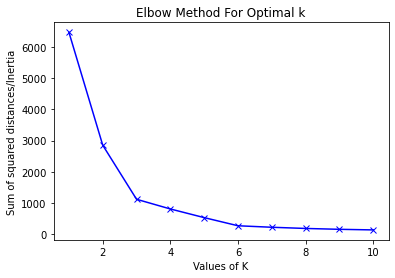

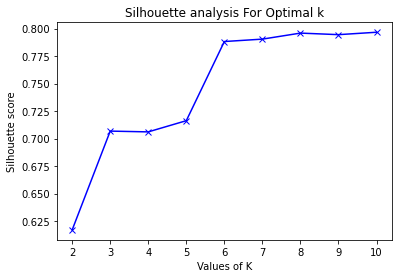

In [245]:
Sum_of_squared_distances = []
K = range(1,11)
for num_clusters in K:
    
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(principal_Df)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
for num_clusters in range_n_clusters:
    
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(principal_Df)
    cluster_labels = kmeans.labels_
 
 # silhouette score
    silhouette_avg.append(silhouette_score(principal_Df, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

By the Elbow method analysis and the Sillhouette analysis, we can find that the best number of clusters is k = 3.

In [246]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.31497572 0.15810927]


In [247]:
final['label'] = final['y_test']
final['label'].replace(0, 'NotFraud',inplace=True)
final['label'].replace(1, 'Fraud',inplace=True)
final.head()

,y_test,pred_rf_u,0,1,2,3,4,5,6,label
0,0,0,0.0,1.0,0.0,400.0,0.0,42.0,1.0,NotFraud
1,0,0,0.0,0.0,1.0,400.0,0.0,48.0,2.0,NotFraud
2,0,0,0.0,0.0,1.0,400.0,4.0,54.0,1.0,NotFraud
3,0,0,0.0,0.0,1.0,400.0,0.0,57.0,2.0,NotFraud
4,0,0,1.0,1.0,0.0,400.0,0.0,27.0,2.0,NotFraud


In [248]:
km = KMeans(n_clusters = 3, random_state = seed)
km.fit(principal_Df)

KMeans(n_clusters=3)

In [249]:
def distance_from_center(component1, component2, label):
    '''
    Calculate the Euclidean distance between a data point and the center of its cluster.
:param float income: the standardized income of the data point 
    :param float age: the standardized age of the data point 
    :param int label: the label of the cluster
    :rtype: float
    :return: The resulting Euclidean distance  
    '''
    center_component1 =  km.cluster_centers_[label,0]
    center_component2 =  km.cluster_centers_[label,1]
    distance = np.sqrt((component1 - center_component1) ** 2 + (component2 - center_component2) ** 2)
    return np.round(distance, 3)

km_final = principal_Df.copy()
km_final['label'] = km.labels_
km_final['distance'] = distance_from_center(km_final.component1, km_final.component2, km_final.label)

In [250]:
outliers_idx = list(km_final.sort_values('distance', ascending=False).head(10).index)
outliers = km_final[km_final.index.isin(outliers_idx)]
print(outliers)

      component1  component2  label  distance
184    -1.669814    3.090543      2     2.666
212    -1.644393    3.086500      2     2.641
228    -1.599258    2.989525      2     2.603
245    -1.613267    3.171347      2     2.607
346     2.569808    5.784870      2     3.009
693     2.870293    6.619104      2     3.881
733     2.626355    5.865674      2     3.107
940    -0.715259    7.155514      2     4.288
1547   -1.607731    2.990872      2     2.611
1936    2.754430    6.547734      2     3.763


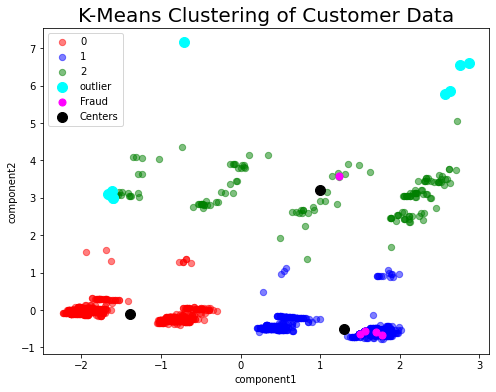

In [251]:
colors=["red","blue","green"]
targets = ["NotFraud", "Fraud"]
plt.figure(figsize=(8,6))
for i in range(np.max(km.labels_)+1):
    plt.scatter(principal_Df[km.labels_==i].component1, principal_Df[km.labels_==i].component2, label=i, c=colors[i], alpha=0.5, s=40)

for target in targets:
    indicesToKeep = final['label'] == target
    
plt.scatter(outliers.component1, outliers.component2, c='aqua', s=100, label = 'outlier')
plt.scatter(principal_Df.loc[indicesToKeep, 'component1'], principal_Df.loc[indicesToKeep, 'component2'], c = 'magenta', label = 'Fraud', s = 50)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], label='Centers', c="black", s=100)
plt.title("K-Means Clustering of Customer Data",size=20)
plt.xlabel("component1")
plt.ylabel("component2")
plt.legend()
plt.show()

Isolation Forest showed that only 1 of the 189 outliers found were classified as Fraud, this represents only 0.005%, and shows that it would not be reliable in fraud identification.

k-means, after the dimentionality reduction process, found just a few number of outliers, only 10, but, as we can see, none of them are frauds.

So, by the results given in Isolation Forest and k-means we can conclude that there are outliers present in our dataset, but the fraudulent actions are not part of them.

### 12. Conclusion

The present project proves useful in understanding and preventing fraudulent claims on vehicle insurance. 

Early on in the project, during the exploratory analysis of the data, we were able to understand some key traits about the accidents, drivers and cars involved in it, which were helpful to create future hypotheses. 

We were also able to perceive that, as expected, the data was unbalanced, a critical factor that should not be ignored.
Unbalanced data, if unattended, could lead to spurious results and, with that in mind, we proceed to apply three distinct data balancing methods, so we could adequately develop our models. 

Numerous models were deployed on each balanced dataset and, through the f1-score, we selected the top 3 to proceed. Furthermore, with the confusion matrices and ROC curves, we decided on the Random Forest model.

Let's analyse some estimated values. Car insurance, in USA, costs around US$ 7.4 billions (check this information here: https://www.propertycasualty360.com/2022/08/25/308-6-billion-the-real-annual-cost-of-insurance-fraud-in-the-u-s/?slreturn=20220918123735) per year in all USA, if we divide for 50 (number of states) we will have the avarage fraud costs per state in one year. Let's say our dataset is from one state and, by the exploratory data analisys, we know it covers three years. Let's now calculate how much money our model could save:

In [252]:
cost = 7400000
cost_per_state = 7400000 / 50
cost_in_3years = 3 * cost_per_state
total_frauds_in_data = df[df['FraudFound_P'] == 1].shape[0]
hit_ratio = 261 / 267
cost_per_fraud = cost_in_3years / total_frauds_in_data
fraud_avoided = hit_ratio * total_frauds_in_data

print(f'Total money saved was: US$ {cost_per_fraud * fraud_avoided:.2f}, without any prediction: US$ {cost_in_3years}, an economy of {(fraud_avoided * cost_per_fraud) / (cost_in_3years) * 100 :.2f}%.')

Total money saved was: US$ 434022.47, without any prediction: US$ 444000.0, an economy of 97.75%.


All things considered, the present project proves to be successful in deploying data science tools and methods to detect and prevent fraudulent claims, providing useful results and notable reduction on economic costs.

### 13. Deploy

In [253]:
# Exporting the best model

pickle.dump(rf_u, open('rf.sav', 'wb'))